In [1]:
import numpy as np

from autooed.problem import build_problem
from autooed.mobo import build_algorithm
from autooed.utils.seed import set_seed
from autooed.utils.initialization import generate_random_initial_samples, load_provided_initial_samples
from autooed.utils.plot import plot_performance_space, plot_performance_metric
from autooed.utils.plot import plot_performance_space_diffcolor
from argparse import ArgumentParser, Namespace
from arguments import get_args


import os
from argparse import ArgumentParser, Namespace
import yaml
from multiprocessing import cpu_count
import pandas as pd

import matplotlib.pyplot as plt

/home/kianoosh/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Change the default values for new argument
def get_general_args(args=None):
    '''
    General arguments: problem and algorithm description, experiment settings
    '''
    parser = ArgumentParser()

    parser.add_argument('--problem', type=str, default='printing3d_dlp', 
        help='optimization problem')
    parser.add_argument('--algo', type=str, default='tsemo',
        help='type of algorithm to use with some predefined arguments, or custom arguments')
    parser.add_argument('--seed', type=int, default=10,
        help='the specific seed to run')
    parser.add_argument('--batch-size', type=int, default=1, 
        help='size of the batch in optimization')
    parser.add_argument('--n-init-sample', type=int, default=0, 
        help='number of initial design samples')
    parser.add_argument('--n-total-sample', type=int, default=43, 
        help='number of total design samples (budget)')

    args, _ = parser.parse_known_args(args)
    return args


def get_surroagte_args(args=None):
    '''
    Arguments for fitting the surrogate model
    '''
    parser = ArgumentParser()

    parser.add_argument('--surrogate', type=str, 
        choices=['gp', 'nn', 'bnn'], default='gp', 
        help='type of the surrogate model')

    args, _ = parser.parse_known_args(args)
    return args


def get_acquisition_args(args=None):
    '''
    Arguments for acquisition function
    '''
    parser = ArgumentParser()

    parser.add_argument('--acquisition', type=str,  
        choices=['identity', 'pi', 'ei', 'ucb', 'ts'], default='identity', 
        help='type of the acquisition function')

    args, _ = parser.parse_known_args(args)
    return args


def get_solver_args(args=None):
    '''
    Arguments for multi-objective solver
    '''
    parser = ArgumentParser()

    # general solver
    parser.add_argument('--solver', type=str, 
        choices=['nsga2', 'moead', 'parego', 'discovery', 'ga', 'cmaes'], default='nsga2', 
        help='type of the multiobjective solver')
    parser.add_argument('--n-process', type=int, default=cpu_count(),
        help='number of processes to be used for parallelization')

    args, _ = parser.parse_known_args(args)
    return args


def get_selection_args(args=None):
    '''
    Arguments for sample selection
    '''
    parser = ArgumentParser()

    parser.add_argument('--selection', type=str,
        choices=['direct', 'hvi', 'random', 'uncertainty'], default='hvi', 
        help='type of selection method for new batch')

    args, _ = parser.parse_known_args(args)
    return args

def get_args():
    '''
    Get arguments from all components
    You can specify args-path argument to directly load arguments from specified yaml file
    '''
    parser = ArgumentParser()
    parser.add_argument('--args-path', type=str, default=None,
        help='used for directly loading arguments from path of argument file')
    args, _ = parser.parse_known_args()

    if args.args_path is None:

        general_args = get_general_args()
        surroagte_args = get_surroagte_args()
        acquisition_args = get_acquisition_args()
        solver_args = get_solver_args()
        selection_args = get_selection_args()

        module_cfg = {
            'surrogate': vars(surroagte_args),
            'acquisition': vars(acquisition_args),
            'solver': vars(solver_args),
            'selection': vars(selection_args),
        }

    else:
        
        with open(args.args_path, 'r') as f:
            all_args = yaml.load(f)
        
        general_args = Namespace(**all_args['general'])
        module_cfg = all_args.copy()
        module_cfg.pop('general')

    return general_args, module_cfg

In [3]:
# load arguments
args, module_cfg = get_args()
print (args.seed)
# set random seed
set_seed(args.seed)

# build problem
problem = build_problem(args.problem)
print(problem)

# build algorithm
algorithm = build_algorithm(args.algo, problem, module_cfg)
print(algorithm)

# generate initial random samples
#X = generate_random_initial_samples(problem, args.n_init_sample)
X = generate_random_initial_samples(problem, args.n_init_sample)
Y = np.array([problem.evaluate_objective(x) for x in X])

print ('read X', X.shape)
print ('read Y', Y.shape)
path = ['/home/kianoosh/github/MOBO_AutoOED/Yuchao_20220511_X.csv', 
        '/home/kianoosh/github/MOBO_AutoOED/Yuchao_20220511_Y.csv']
X, Y = load_provided_initial_samples(path)
Y = -Y
print ('read X', X.shape)
print ('read Y', Y.shape)

X0 = X
Y0 = Y

# optimization
while len(X) < args.n_total_sample:

    # propose design samples
    X_next = algorithm.optimize(X, Y, None, args.batch_size)

    # evaluate proposed samples
    Y_next = np.array([problem.evaluate_objective(x) for x in X_next])

    # combine into dataset
    X = np.vstack([X, X_next])
    Y = np.vstack([Y, Y_next])
    print(f'{len(X)}/{args.n_total_sample} complete')


10
========== Problem Definition ==========
# name: printing3d_dlp
# n_var: 6
# n_obj: 2
# n_constr: 0


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.configuration import Configuration
Configuration.show_compile_hint = False

========== Algorithm Setup ==========
# algorithm: TSEMO
# surrogate: GaussianProcess
# acquisition: ThompsonSampling
# solver: NSGA2
# selection: HypervolumeImprovement

read X (0, 6)
read Y (0,)
read X (40, 6)
read Y (40, 2)


/home/kianoosh/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 31.622776601683793. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/kianoosh/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 0.0024787521766663585. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/kianoosh/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 31.622776601683793. Increasing the bound and calling fit

 Out['G']  [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.45]
 Out['G']  [ 0.41  0.09  0.19  0.3   0.01 -0.01  0.12  0.14  0.    1.12 -0.05 -0.15
  0.04 -0.01  0.07 -0.51 -0.28 -0.09  0.01 -0.25  0.47  0.02  0.   -0.13
  0.    0.03  0.09  0.   -0.06  0.03  0.48 -0.32  0.05 -0.11 -0.02 -0.02
 -0.61  0.1   0.07  0.08 -0.25 -0.1  -0.04  0.27 -0.3  -0.04  0.12  0.3
  0.07  0.12  0.04 -0.4   0.03 -0.01 -0.2   0.25 -0.39 -0.01 -0.35  0.3
  0.32 -0.28 -0.03  0.86 -0.1   0.01 -0.26  0.    0.13  0.12  0.1  -0.2
  0.39  1.1   0.   -0.2  -0.04  0.04 -0.1  -0.02 -0.69 -0.21  0.05 -0.01
 -0.07  0.    0.02  0.46 -0.33 -0.04 -0.09 -0.01 -0.19  0.25  1.01  0.26
 -0.07  0.27 -0.45 -0.1  -0.44 -0.57  0.02  0.05 -0.12 -0.1  -0.04 -0.28
  0.03  0.18  0.87 -0.04 -0.15  0.29  0.27  0.01 -0.02  0.01 -0.49  0.02
  0.01  0.   -0.03 -0.11 -0.04 -0.2   0.9   0.

/home/kianoosh/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


 Out['G']  [-0.19  0.02 -0.44 -0.49  0.22 -0.18  0.09  0.08 -0.34  0.01 -0.23  0.05
 -0.27  0.42 -0.3   0.15 -0.1   0.08 -0.22  0.   -0.2   0.39 -0.09 -0.16
  0.2  -0.14  0.37  0.26 -0.38 -0.66 -0.47  0.07 -0.08  0.91 -0.17 -0.18
  0.01  0.05 -0.03 -0.17 -0.01 -0.24 -0.02  0.16  0.1  -0.2   0.22 -0.17
  0.    0.24  0.07 -0.33 -0.2   0.04 -0.51 -0.25  0.1  -0.25  0.23  0.06
  0.06  0.29 -0.19  0.03  0.31  0.    0.14  0.12  0.08 -0.19 -0.08  0.11
 -0.13  0.27 -0.12  0.11  0.   -0.27  0.1  -0.34  0.25 -0.09  0.01 -0.09
 -0.44 -0.41 -0.3  -0.28  0.07 -0.04 -0.45  0.02 -0.32  0.22  0.43  0.18
 -0.37 -0.19  0.3  -0.15  0.13 -0.24 -0.27  0.04 -0.05  0.32 -0.03 -0.29
  0.18 -0.08 -0.42 -0.03  0.16  0.1  -0.03 -0.26 -0.01  0.    0.56 -0.31
 -0.28 -0.11  0.03  0.01  0.08  0.47  0.19  0.27  0.06 -0.33  0.    0.25
 -0.08 -0.39 -0.44  0.37 -0.35  0.1  -0.4   0.28 -0.37 -0.23 -0.16  0.24
  0.    0.   -0.15  0.3   0.02  0.29 -0.08 -0.36  0.23 -0.63 -0.43 -0.35
 -0.17  0.    0.19  0.07 -0.02 -0.21 -0.

 Out['G']  [-0.21  0.03 -0.09 -0.2  -0.2  -0.08  0.3  -0.05 -0.11 -0.02 -0.03 -0.12
 -0.09 -0.13 -0.28 -0.19 -0.17  0.01  0.01 -0.15  0.06 -0.27 -0.23 -0.08
  0.27  0.05 -0.17 -0.34 -0.11  0.17 -0.07 -0.03 -0.2  -0.08 -0.09 -0.32
  0.35  0.04 -0.15 -0.07  0.12  0.07 -0.36 -0.34 -0.04 -0.01  0.03  0.
 -0.24  0.05 -0.1  -0.19  0.28 -0.26 -0.3  -0.07 -0.28 -0.16  0.04  0.06
 -0.21 -0.09  0.   -0.01  0.36 -0.01 -0.01 -0.53 -0.16  0.03 -0.02 -0.02
 -0.39 -0.24  0.    0.24 -0.02  0.07 -0.22 -0.03  0.21  0.07 -0.15 -0.06
  0.05 -0.16 -0.02 -0.02 -0.16 -0.1   0.   -0.28 -0.24 -0.1   0.38 -0.3
  0.31  0.04  0.17 -0.1  -0.01  0.07  0.45 -0.15 -0.08  0.16 -0.02  0.08
 -0.13 -0.15 -0.1  -0.12 -0.03 -0.09 -0.13 -0.39  0.04 -0.06 -0.1  -0.23
 -0.04 -0.02 -0.23 -0.05  0.48  0.17 -0.23 -0.03  0.02 -0.01  0.05 -0.44
  0.06 -0.16 -0.34 -0.03 -0.06 -0.29 -0.03 -0.1   0.03  0.05 -0.33 -0.34
 -0.15 -0.2  -0.25 -0.07  0.12  0.24 -0.17  0.38 -0.22 -0.11 -0.01  0.
 -0.03 -0.07 -0.03 -0.26  0.03 -0.25  0.11 -0

 Out['G']  [ 0.03 -0.35 -0.33 -0.04 -0.09  0.06 -0.16 -0.06 -0.25 -0.08 -0.14 -0.39
 -0.29 -0.14 -0.24 -0.04 -0.11  0.1  -0.21 -0.1  -0.1  -0.15 -0.11 -0.1
 -0.33  0.06 -0.13 -0.09  0.04 -0.04 -0.1   0.1  -0.14 -0.31  0.18  0.05
 -0.09 -0.13 -0.04 -0.38 -0.31 -0.05 -0.04  0.22 -0.14 -0.09 -0.11 -0.05
 -0.11 -0.08 -0.2  -0.1  -0.15 -0.09 -0.08 -0.1  -0.11 -0.09 -0.12 -0.21
 -0.05 -0.05 -0.19  0.23 -0.37  0.19 -0.06 -0.06 -0.16  0.01 -0.22 -0.09
 -0.03  0.07 -0.11 -0.02 -0.16  0.04 -0.05 -0.36 -0.08 -0.04 -0.15  0.01
  0.09 -0.21  0.34 -0.04 -0.07 -0.02 -0.04  0.   -0.33  0.32 -0.14 -0.01
 -0.05 -0.12  0.37  0.04 -0.11 -0.15 -0.13  0.04 -0.13 -0.11 -0.21  0.
  0.38  0.08 -0.19  0.02 -0.02 -0.08  0.1  -0.03  0.04 -0.04 -0.07  0.29
 -0.17 -0.06  0.06 -0.07 -0.06  0.09 -0.05 -0.2   0.   -0.01 -0.15 -0.21
  0.12  0.04 -0.08 -0.01 -0.06 -0.15 -0.12 -0.11 -0.1  -0.24 -0.11 -0.04
 -0.07 -0.07  0.   -0.09 -0.1  -0.11 -0.07 -0.12  0.15 -0.16 -0.22 -0.13
 -0.04 -0.04 -0.09 -0.26 -0.08 -0.18 -0.15 

 Out['G']  [-0.06 -0.08 -0.07 -0.05 -0.21 -0.27 -0.08  0.09 -0.1  -0.06 -0.05 -0.35
 -0.07 -0.08 -0.15  0.06 -0.15 -0.09 -0.06  0.09 -0.27  0.07 -0.13 -0.08
 -0.3  -0.09 -0.01 -0.1  -0.04 -0.31 -0.1  -0.21 -0.06 -0.03 -0.02 -0.05
 -0.04 -0.06 -0.02 -0.08 -0.04 -0.1  -0.06 -0.18 -0.15  0.02 -0.12 -0.02
 -0.13 -0.03 -0.01 -0.14 -0.14 -0.06 -0.04 -0.15 -0.1   0.07 -0.02 -0.17
 -0.29 -0.09 -0.15 -0.07 -0.15 -0.18 -0.08  0.02 -0.1  -0.11 -0.17  0.06
 -0.15 -0.18 -0.09 -0.03 -0.04 -0.17 -0.07 -0.37 -0.19 -0.02 -0.15 -0.04
  0.04 -0.08 -0.04 -0.06  0.   -0.06 -0.47 -0.04  0.   -0.13  0.03 -0.23
 -0.03 -0.08 -0.13 -0.1  -0.08 -0.04 -0.02 -0.04 -0.17 -0.19 -0.31  0.01
 -0.06 -0.1   0.13  0.01 -0.05 -0.08 -0.14  0.   -0.02 -0.2  -0.12 -0.26
 -0.16 -0.16  0.02 -0.1   0.   -0.08 -0.18 -0.07 -0.12  0.02 -0.07 -0.05
 -0.17 -0.09 -0.08 -0.12 -0.05  0.01 -0.06  0.01 -0.16 -0.12  0.03 -0.06
 -0.44 -0.01  0.03 -0.01 -0.28  0.05 -0.07 -0.05 -0.05 -0.2  -0.08 -0.2
 -0.18 -0.37 -0.19  0.26 -0.06 -0.1  -0.1

 Out['G']  [-0.2  -0.05 -0.02 -0.26 -0.19  0.05 -0.01 -0.03 -0.02 -0.03 -0.03 -0.21
 -0.05 -0.05 -0.48 -0.09 -0.05 -0.07 -0.13 -0.09  0.07 -0.05 -0.05 -0.21
 -0.04 -0.05 -0.06 -0.05 -0.16 -0.01 -0.14  0.02 -0.16 -0.17 -0.01 -0.01
 -0.11 -0.03  0.03 -0.05 -0.22 -0.31 -0.37 -0.13 -0.08 -0.07  0.01 -0.01
 -0.25 -0.05 -0.04 -0.21  0.08 -0.21  0.05 -0.37 -0.11 -0.02 -0.04 -0.37
 -0.03 -0.34 -0.18 -0.01 -0.06 -0.27 -0.11 -0.02 -0.2  -0.17 -0.18 -0.24
 -0.06 -0.25 -0.09 -0.04 -0.03 -0.13  0.07 -0.02 -0.33 -0.04 -0.52 -0.06
  0.05 -0.04 -0.08 -0.13 -0.08 -0.23 -0.05 -0.06 -0.07 -0.22 -0.08 -0.15
 -0.36 -0.06 -0.34 -0.23 -0.04 -0.17 -0.06 -0.13 -0.14 -0.19 -0.13 -0.02
  0.07 -0.03 -0.03 -0.34 -0.34 -0.01 -0.32 -0.17 -0.03 -0.08 -0.08 -0.04
 -0.26 -0.12 -0.24 -0.02 -0.08 -0.45 -0.04 -0.13 -0.1  -0.04 -0.03 -0.06
 -0.28 -0.17 -0.16 -0.07  0.1  -0.07 -0.11  0.   -0.06 -0.15 -0.19 -0.16
 -0.05 -0.16 -0.34 -0.08  0.13 -0.03 -0.12 -0.12 -0.31  0.01 -0.2  -0.11
 -0.2  -0.14 -0.06 -0.08 -0.22 -0.06 -0.

 Out['G']  [-0.13  0.01 -0.07 -0.04 -0.18 -0.36 -0.02 -0.12 -0.05 -0.03 -0.06 -0.04
 -0.13 -0.03  0.09 -0.18 -0.15 -0.22 -0.15 -0.03 -0.42 -0.2   0.15  0.06
 -0.08 -0.05  0.05  0.19 -0.16 -0.04 -0.08 -0.01 -0.05 -0.04 -0.2  -0.22
 -0.12 -0.21 -0.21 -0.1  -0.03 -0.09 -0.21 -0.15  0.03 -0.15 -0.05 -0.1
  0.09 -0.35 -0.17 -0.07 -0.19 -0.01  0.05 -0.23 -0.08 -0.12 -0.13 -0.13
  0.05  0.1  -0.1  -0.07 -0.05 -0.2  -0.04 -0.42  0.02 -0.12 -0.11 -0.09
 -0.13 -0.09 -0.01 -0.21 -0.06 -0.05 -0.21 -0.11  0.05 -0.18 -0.29 -0.03
 -0.22 -0.04 -0.06 -0.11 -0.04 -0.35 -0.05  0.01 -0.09 -0.01 -0.16 -0.02
 -0.08 -0.05 -0.13 -0.17 -0.07  0.03 -0.21 -0.23 -0.16  0.04 -0.14 -0.15
 -0.24  0.02 -0.01 -0.02  0.1  -0.17 -0.19 -0.28 -0.14 -0.29 -0.23 -0.26
 -0.02 -0.1  -0.45 -0.13 -0.03 -0.04 -0.19 -0.04 -0.06 -0.02 -0.15  0.
  0.08 -0.03 -0.08 -0.13 -0.06 -0.23 -0.24  0.09 -0.37  0.04 -0.08 -0.28
 -0.02 -0.12 -0.25 -0.09 -0.19 -0.04 -0.05 -0.08 -0.12  0.02 -0.2  -0.33
 -0.07 -0.08 -0.1  -0.05 -0.16  0.02 -0.09 

 Out['G']  [-0.03 -0.03 -0.09 -0.27 -0.15 -0.02 -0.07 -0.07 -0.14 -0.15  0.08 -0.03
 -0.11 -0.21 -0.01 -0.28 -0.53 -0.04 -0.17 -0.06 -0.06 -0.04 -0.22 -0.26
 -0.12 -0.13 -0.15 -0.27 -0.06 -0.12  0.07 -0.05  0.05 -0.1  -0.35 -0.01
 -0.04 -0.12 -0.05 -0.17 -0.02 -0.1  -0.15 -0.03 -0.05 -0.09 -0.16 -0.21
 -0.06  0.02 -0.05 -0.04 -0.2  -0.16  0.11  0.09 -0.16  0.04 -0.07 -0.1
  0.09 -0.1  -0.18 -0.39 -0.18 -0.15 -0.05 -0.14 -0.08 -0.08 -0.06 -0.07
 -0.07 -0.23 -0.14  0.05 -0.08 -0.03 -0.12 -0.09 -0.03 -0.05 -0.16 -0.03
 -0.06 -0.34 -0.22 -0.03 -0.29 -0.16 -0.21  0.01 -0.08 -0.25 -0.12 -0.08
 -0.01 -0.07 -0.02 -0.16  0.09 -0.07 -0.07 -0.09 -0.05 -0.11 -0.3  -0.06
  0.09 -0.02  0.08 -0.08 -0.08 -0.32 -0.12 -0.2  -0.14  0.05 -0.05 -0.05
 -0.03 -0.11 -0.04  0.06 -0.1  -0.19 -0.1  -0.03 -0.06 -0.06 -0.08 -0.02
 -0.16 -0.12 -0.13 -0.12 -0.05 -0.02 -0.19 -0.07 -0.17 -0.04 -0.17 -0.19
 -0.04 -0.02 -0.02 -0.17 -0.23 -0.16 -0.18 -0.23 -0.03 -0.05 -0.11 -0.29
 -0.02 -0.19 -0.05 -0.02 -0.03 -0.04 -0.0

 Out['G']  [-0.05 -0.02 -0.08 -0.13 -0.12 -0.05 -0.26 -0.07 -0.02 -0.24 -0.07 -0.21
 -0.1  -0.21 -0.21 -0.38  0.02 -0.2  -0.05 -0.04 -0.16 -0.08 -0.17 -0.15
 -0.05 -0.08 -0.14 -0.14 -0.08 -0.06 -0.13 -0.23 -0.07  0.   -0.1  -0.34
  0.05 -0.04  0.01 -0.03 -0.09 -0.22 -0.11 -0.06  0.08 -0.05  0.   -0.05
 -0.01 -0.1  -0.04 -0.08 -0.06 -0.12 -0.03  0.    0.14 -0.16 -0.22 -0.05
 -0.1  -0.05 -0.03 -0.07 -0.2  -0.22 -0.02 -0.08 -0.41 -0.08 -0.03 -0.06
 -0.01 -0.18 -0.2  -0.23 -0.17 -0.05 -0.03  0.01 -0.1  -0.06 -0.08 -0.04
 -0.04 -0.05  0.01 -0.23 -0.06 -0.05 -0.07  0.02 -0.14 -0.31  0.01 -0.35
 -0.24 -0.12 -0.07  0.01 -0.02  0.07 -0.03 -0.01  0.03 -0.17 -0.04  0.01
 -0.03 -0.35 -0.03 -0.19 -0.19  0.05 -0.12 -0.05 -0.05 -0.15 -0.17 -0.29
 -0.22  0.1  -0.04 -0.38 -0.07 -0.08 -0.07 -0.04  0.04  0.07 -0.02 -0.05
 -0.1  -0.13 -0.22 -0.09 -0.08 -0.23 -0.02 -0.01 -0.12 -0.06 -0.15  0.01
 -0.03 -0.04 -0.08 -0.05 -0.03 -0.26 -0.05 -0.13 -0.16 -0.06 -0.33 -0.1
 -0.01 -0.06 -0.2  -0.06 -0.09 -0.03  0.0

 Out['G']  [-0.05 -0.05 -0.19  0.01  0.03  0.05 -0.02 -0.31 -0.04 -0.18 -0.06 -0.07
 -0.22 -0.05 -0.28 -0.03  0.01 -0.17 -0.19 -0.32 -0.11 -0.05 -0.13 -0.14
 -0.05 -0.11 -0.1  -0.11 -0.05  0.06 -0.29 -0.14 -0.23 -0.03 -0.15 -0.08
 -0.04 -0.01 -0.03  0.04 -0.02 -0.09 -0.02 -0.19 -0.05 -0.07 -0.17  0.08
 -0.06 -0.09 -0.04 -0.03 -0.01  0.   -0.02 -0.18  0.14 -0.2   0.11  0.07
 -0.03 -0.04 -0.16 -0.15 -0.06 -0.07 -0.08 -0.12  0.03 -0.05 -0.04  0.11
 -0.12 -0.01 -0.03 -0.08  0.02 -0.19 -0.3  -0.18 -0.15  0.02 -0.09 -0.04
  0.1  -0.26 -0.04 -0.02 -0.09 -0.01 -0.26 -0.05 -0.08 -0.04 -0.05 -0.08
 -0.24 -0.13 -0.07 -0.05 -0.09 -0.07 -0.03 -0.05 -0.19 -0.09  0.06  0.03
 -0.05 -0.03  0.01  0.08 -0.03 -0.24  0.   -0.11 -0.09 -0.13 -0.11 -0.16
 -0.04 -0.14 -0.11 -0.02  0.   -0.14 -0.01 -0.04 -0.05  0.02 -0.25 -0.16
 -0.03 -0.31 -0.11 -0.16 -0.03 -0.07 -0.12 -0.09 -0.06 -0.05 -0.06 -0.07
 -0.03 -0.01 -0.35 -0.05 -0.04 -0.05  0.   -0.07 -0.01 -0.2  -0.45 -0.04
 -0.24 -0.34 -0.09 -0.02  0.   -0.16 -0.

 Out['G']  [-0.03 -0.15 -0.11  0.   -0.17 -0.06 -0.02 -0.02 -0.08 -0.15  0.   -0.03
 -0.06 -0.05  0.11 -0.14  0.02  0.   -0.19  0.01 -0.07 -0.09 -0.06 -0.15
 -0.03 -0.1  -0.01 -0.23 -0.05 -0.09 -0.14 -0.09  0.03 -0.15 -0.07 -0.24
 -0.34 -0.07 -0.24 -0.05 -0.02 -0.12  0.02 -0.07 -0.03  0.17 -0.02 -0.1
 -0.12 -0.17 -0.04 -0.05 -0.16 -0.04 -0.25 -0.03  0.02 -0.03  0.03 -0.37
 -0.28  0.   -0.05 -0.09 -0.11 -0.07 -0.14 -0.11 -0.03 -0.01 -0.03 -0.17
 -0.07 -0.24 -0.04 -0.18 -0.16 -0.12 -0.04 -0.08  0.02  0.1  -0.03 -0.2
 -0.03 -0.1  -0.06  0.09  0.19 -0.07 -0.04  0.08 -0.1  -0.06 -0.16  0.01
 -0.04 -0.05 -0.08  0.02 -0.2  -0.2   0.02 -0.16 -0.05 -0.19 -0.02 -0.07
 -0.38 -0.14 -0.02 -0.05 -0.09 -0.1   0.   -0.14  0.   -0.02 -0.07 -0.19
 -0.1  -0.04 -0.16 -0.04 -0.09 -0.07 -0.12  0.01 -0.05 -0.1  -0.14  0.13
  0.04 -0.11 -0.18 -0.04  0.   -0.02 -0.16 -0.03 -0.1  -0.09 -0.06 -0.06
  0.04 -0.2  -0.2  -0.04  0.   -0.06 -0.04 -0.09 -0.03 -0.01 -0.04 -0.15
 -0.02 -0.1   0.22  0.11 -0.05 -0.02  0.  

 Out['G']  [-0.08  0.04 -0.22 -0.09 -0.08 -0.23 -0.12 -0.1   0.04  0.05 -0.23 -0.25
 -0.12 -0.03 -0.34 -0.14 -0.25 -0.1  -0.05 -0.11 -0.02 -0.19 -0.13 -0.21
 -0.03 -0.06 -0.03 -0.06  0.03 -0.11 -0.25 -0.19 -0.02  0.03 -0.07 -0.11
 -0.04  0.02 -0.05 -0.04 -0.04 -0.32 -0.03 -0.12 -0.28 -0.03 -0.1  -0.2
 -0.05 -0.08 -0.31 -0.06 -0.22 -0.17  0.04 -0.05 -0.18 -0.1  -0.02  0.01
 -0.07  0.09 -0.19 -0.01 -0.42 -0.09  0.06 -0.21  0.03 -0.13 -0.15 -0.08
  0.02 -0.08 -0.05 -0.21  0.07 -0.1  -0.08 -0.1  -0.12 -0.33 -0.15 -0.04
  0.06 -0.07 -0.04 -0.04 -0.22 -0.11  0.1  -0.03 -0.23 -0.22 -0.17 -0.04
  0.1  -0.11 -0.1   0.07 -0.24 -0.05  0.08  0.01  0.06 -0.15 -0.13  0.05
  0.03 -0.09  0.05  0.07 -0.15 -0.15  0.05 -0.09 -0.17 -0.13 -0.22 -0.2
 -0.19 -0.02 -0.15  0.   -0.17 -0.01 -0.02 -0.17  0.   -0.17 -0.03  0.03
 -0.04 -0.24 -0.24  0.03 -0.11  0.03 -0.04 -0.13 -0.23 -0.04 -0.02 -0.04
 -0.19  0.    0.01 -0.16  0.08 -0.01 -0.24 -0.07 -0.27 -0.07 -0.03 -0.01
 -0.16  0.02 -0.26 -0.17 -0.02  0.15 -0.06

 Out['G']  [-0.44 -0.32  0.06 -0.01 -0.08 -0.01 -0.18  0.02 -0.07 -0.04  0.01 -0.14
  0.05 -0.33 -0.04 -0.28  0.01 -0.04  0.01  0.09  0.13 -0.26 -0.07 -0.04
  0.02 -0.02 -0.05 -0.26 -0.29 -0.26 -0.05 -0.06 -0.01 -0.06 -0.29 -0.05
  0.04 -0.01 -0.19 -0.12 -0.03 -0.1  -0.12 -0.08 -0.09 -0.2  -0.31 -0.05
 -0.03  0.1  -0.02  0.05 -0.05 -0.08 -0.19 -0.14 -0.24 -0.07 -0.16 -0.01
 -0.05 -0.25 -0.12 -0.04 -0.13 -0.05 -0.2   0.02 -0.03 -0.11 -0.04 -0.25
 -0.13 -0.07 -0.02  0.01  0.1  -0.03 -0.06  0.04 -0.14 -0.23 -0.26 -0.17
 -0.15 -0.03 -0.05 -0.12  0.08  0.08 -0.03 -0.08  0.03 -0.24 -0.19  0.05
 -0.1  -0.26 -0.04 -0.26 -0.02 -0.01 -0.05 -0.13 -0.21 -0.01 -0.11 -0.02
  0.16  0.02  0.1   0.03 -0.24 -0.3  -0.13 -0.32 -0.04 -0.16 -0.05 -0.04
 -0.01 -0.16 -0.04 -0.05 -0.13  0.03  0.04 -0.18 -0.04 -0.16  0.03 -0.01
 -0.02 -0.19 -0.02 -0.23 -0.28 -0.2  -0.02 -0.09  0.01 -0.08 -0.21 -0.01
 -0.09 -0.17 -0.33 -0.04 -0.24 -0.16 -0.12 -0.03 -0.01 -0.03 -0.13 -0.04
 -0.1  -0.03 -0.05 -0.16 -0.21 -0.3  -0.

 Out['G']  [ 0.04 -0.2  -0.07 -0.25 -0.19 -0.02 -0.14 -0.22  0.05 -0.15 -0.32 -0.17
 -0.07 -0.01 -0.05 -0.02 -0.21 -0.23 -0.05 -0.13 -0.06 -0.21 -0.15 -0.07
  0.04 -0.03 -0.5  -0.17  0.   -0.07  0.05 -0.01 -0.04  0.   -0.03 -0.11
 -0.01 -0.18 -0.01 -0.12 -0.06 -0.24 -0.05 -0.05 -0.1  -0.21  0.03 -0.15
 -0.29  0.   -0.09 -0.02 -0.34  0.02  0.02 -0.11 -0.06 -0.11 -0.29 -0.2
 -0.14  0.01 -0.02 -0.01 -0.04 -0.15 -0.07 -0.14 -0.37  0.08 -0.01 -0.1
 -0.16  0.   -0.08 -0.1  -0.03 -0.06 -0.2  -0.12 -0.25 -0.11  0.13 -0.05
 -0.08 -0.18 -0.04 -0.17 -0.15  0.01 -0.03 -0.05 -0.05 -0.32 -0.08 -0.08
 -0.23 -0.07 -0.2  -0.03 -0.05  0.05 -0.35 -0.16  0.11 -0.19 -0.06 -0.06
  0.02 -0.02  0.02 -0.22 -0.2  -0.26 -0.01 -0.04 -0.19  0.07 -0.2  -0.05
  0.16  0.05 -0.03 -0.02 -0.03 -0.02 -0.07 -0.08 -0.01 -0.04 -0.09 -0.21
 -0.1  -0.07 -0.06 -0.18  0.14 -0.22 -0.25  0.04 -0.16 -0.11 -0.15 -0.08
 -0.15 -0.14 -0.03 -0.05 -0.29 -0.11 -0.21 -0.18 -0.19 -0.14 -0.04 -0.07
 -0.03 -0.04 -0.09 -0.07  0.    0.03  0.19

 Out['G']  [-0.07 -0.22 -0.03 -0.05 -0.13 -0.21 -0.2  -0.15 -0.05 -0.06 -0.07 -0.25
 -0.24 -0.02 -0.02 -0.03 -0.27  0.03  0.05 -0.01 -0.08 -0.25 -0.23  0.05
  0.06 -0.03  0.03 -0.13 -0.04 -0.3   0.17 -0.12 -0.04 -0.16 -0.04 -0.07
 -0.02 -0.02 -0.05 -0.01  0.08 -0.17 -0.21 -0.22 -0.11 -0.19 -0.04 -0.05
 -0.18 -0.06 -0.02 -0.05  0.08 -0.13 -0.26 -0.06  0.04 -0.21 -0.04 -0.04
 -0.02 -0.16 -0.3  -0.08  0.05 -0.24 -0.09 -0.16 -0.17 -0.06 -0.13 -0.16
 -0.05 -0.29 -0.23 -0.04 -0.04 -0.08 -0.01 -0.06 -0.26 -0.22 -0.08 -0.11
 -0.07 -0.02 -0.2  -0.04 -0.05  0.01 -0.21 -0.07 -0.43 -0.02 -0.39 -0.07
 -0.1   0.05 -0.03 -0.15 -0.03 -0.03 -0.03 -0.14 -0.03  0.02 -0.34 -0.14
 -0.23 -0.19 -0.11 -0.05  0.04 -0.23 -0.22 -0.07 -0.03  0.04 -0.07 -0.12
 -0.02 -0.12 -0.25 -0.16 -0.17 -0.51 -0.03  0.01 -0.05  0.   -0.15 -0.1
 -0.08 -0.17 -0.29 -0.17 -0.03 -0.07 -0.05 -0.22 -0.24 -0.03 -0.2  -0.3
 -0.19 -0.07 -0.02 -0.23 -0.14 -0.07  0.   -0.17 -0.16 -0.03 -0.02 -0.03
 -0.09 -0.02 -0.03 -0.24 -0.23 -0.09 -0.07

 Out['G']  [-0.06  0.1  -0.05  0.08 -0.08 -0.06 -0.04  0.   -0.19  0.03  0.03 -0.16
  0.08  0.08 -0.17 -0.03 -0.05  0.14 -0.12 -0.14 -0.21 -0.05 -0.06 -0.02
 -0.03 -0.05 -0.02  0.06 -0.2  -0.05 -0.25 -0.21 -0.02 -0.06 -0.03 -0.17
 -0.06 -0.02 -0.05 -0.08 -0.2  -0.13 -0.07 -0.05 -0.19 -0.23 -0.17  0.09
 -0.04  0.03 -0.01 -0.07 -0.21 -0.18  0.07 -0.07  0.03 -0.04 -0.27 -0.01
 -0.16 -0.39 -0.03 -0.15 -0.17 -0.15 -0.05 -0.18 -0.1  -0.11 -0.26  0.
 -0.04 -0.01 -0.16 -0.11  0.   -0.05 -0.16 -0.05  0.   -0.01 -0.08 -0.09
 -0.05 -0.1  -0.22 -0.24 -0.04 -0.21 -0.2   0.02 -0.02 -0.02  0.   -0.21
 -0.27 -0.35 -0.12  0.06 -0.28 -0.29 -0.28 -0.09 -0.37 -0.01 -0.29 -0.19
 -0.02 -0.07 -0.06 -0.35 -0.05 -0.23 -0.04 -0.07 -0.21  0.05 -0.24 -0.2
 -0.17 -0.05  0.08 -0.27 -0.09 -0.06 -0.3   0.04 -0.02 -0.05 -0.22 -0.05
 -0.07 -0.07  0.05 -0.08 -0.05 -0.07 -0.16 -0.08 -0.2  -0.35 -0.29  0.03
 -0.19 -0.22 -0.06  0.   -0.15 -0.18 -0.13 -0.01 -0.19 -0.01 -0.1   0.12
 -0.32 -0.27 -0.15 -0.15 -0.11 -0.01 -0.03 

 Out['G']  [-0.17 -0.11 -0.05  0.01  0.02 -0.05 -0.07 -0.33 -0.22 -0.2  -0.19 -0.06
  0.2  -0.13  0.06 -0.2  -0.02 -0.04 -0.08 -0.02  0.   -0.07 -0.05 -0.35
 -0.03  0.23  0.02  0.01 -0.18  0.03  0.07 -0.22 -0.06 -0.11 -0.15 -0.14
 -0.03 -0.06 -0.05  0.12 -0.05 -0.22 -0.13 -0.24 -0.1  -0.01 -0.36 -0.05
 -0.29 -0.19 -0.15  0.1  -0.04 -0.02 -0.12 -0.21 -0.22 -0.13 -0.15 -0.01
 -0.01 -0.1  -0.08 -0.05 -0.05 -0.08 -0.03 -0.03 -0.09 -0.09 -0.43  0.13
 -0.03 -0.04  0.02  0.08  0.   -0.16 -0.05  0.04 -0.04 -0.03 -0.06 -0.03
 -0.25  0.03 -0.11 -0.11 -0.03 -0.22  0.03 -0.17 -0.32 -0.11  0.01 -0.08
  0.03 -0.29 -0.05 -0.2  -0.2   0.08 -0.17 -0.11 -0.02 -0.1  -0.29 -0.16
 -0.15 -0.02 -0.04 -0.05 -0.17 -0.03 -0.04 -0.07  0.04 -0.38 -0.28 -0.17
 -0.05 -0.37  0.03 -0.06 -0.21 -0.05  0.04 -0.04  0.04 -0.07 -0.17 -0.2
 -0.18  0.    0.15 -0.04  0.02  0.07 -0.01  0.04 -0.2  -0.21 -0.2  -0.04
 -0.32 -0.16 -0.04 -0.21  0.02 -0.19 -0.27 -0.08 -0.05 -0.08 -0.22 -0.05
 -0.11 -0.06 -0.04 -0.02 -0.03 -0.02 -0.3

 Out['G']  [ 0.09 -0.27  0.   -0.43 -0.11  0.05 -0.14 -0.02 -0.11 -0.11 -0.04 -0.12
  0.01  0.04 -0.02 -0.04 -0.04 -0.08 -0.04 -0.22 -0.08 -0.01 -0.06 -0.23
 -0.03 -0.25 -0.04 -0.17  0.13  0.06 -0.06 -0.11  0.06  0.12 -0.26 -0.05
 -0.09 -0.09 -0.24 -0.06  0.    0.01 -0.12 -0.01  0.03 -0.13 -0.04 -0.01
 -0.01  0.18 -0.02 -0.24  0.05  0.02 -0.05 -0.09 -0.06  0.05  0.12 -0.17
 -0.02 -0.02 -0.09 -0.12 -0.23 -0.02 -0.17 -0.03 -0.21 -0.41 -0.06 -0.06
 -0.02 -0.01 -0.06 -0.09 -0.12 -0.14  0.14 -0.15 -0.21 -0.19 -0.15 -0.04
 -0.39 -0.35 -0.14  0.05 -0.05  0.06 -0.04 -0.02 -0.01 -0.26  0.1  -0.16
 -0.25 -0.05  0.02 -0.33 -0.13 -0.02  0.08 -0.11 -0.26 -0.32 -0.05 -0.05
 -0.13 -0.03 -0.17 -0.13 -0.1  -0.04 -0.01 -0.18 -0.12 -0.04 -0.06 -0.04
 -0.02  0.05 -0.08 -0.03 -0.13 -0.07 -0.09 -0.05 -0.35 -0.03 -0.23 -0.13
 -0.43 -0.19 -0.01 -0.13 -0.15  0.08 -0.04 -0.15 -0.08 -0.03 -0.19 -0.24
 -0.17 -0.17 -0.11 -0.01 -0.25 -0.08 -0.26 -0.22 -0.07 -0.07  0.02 -0.06
 -0.29 -0.23 -0.17 -0.03 -0.05 -0.05  0.

 Out['G']  [-0.26 -0.12 -0.01 -0.09 -0.02 -0.22 -0.03 -0.1   0.11 -0.08 -0.17 -0.19
 -0.08  0.    0.02 -0.05 -0.18 -0.05 -0.37  0.   -0.21 -0.42  0.1  -0.09
 -0.15 -0.07 -0.16  0.04 -0.2  -0.04  0.04  0.09 -0.03  0.12 -0.04 -0.22
 -0.12  0.01 -0.11 -0.11 -0.19 -0.09  0.1  -0.06 -0.03 -0.05 -0.03 -0.05
 -0.08 -0.03 -0.23 -0.12 -0.31 -0.07 -0.18  0.05 -0.11 -0.29  0.01 -0.22
 -0.2  -0.05 -0.14 -0.1   0.02 -0.07 -0.06 -0.29 -0.1  -0.3  -0.07 -0.02
 -0.19 -0.06 -0.2  -0.01 -0.08  0.   -0.1  -0.11  0.   -0.2  -0.18  0.01
 -0.15  0.13 -0.24  0.07 -0.15  0.04 -0.22 -0.31 -0.06 -0.14  0.   -0.11
  0.   -0.12 -0.14  0.   -0.13  0.   -0.05 -0.03  0.01 -0.03 -0.28 -0.13
 -0.15  0.03 -0.16 -0.02 -0.23 -0.06 -0.02 -0.21 -0.04 -0.16 -0.2  -0.12
 -0.28 -0.38  0.06 -0.06 -0.2  -0.17 -0.19 -0.21 -0.21 -0.33 -0.08 -0.16
 -0.33 -0.03  0.1  -0.07  0.04 -0.02 -0.09 -0.4  -0.24 -0.2  -0.1  -0.02
 -0.08 -0.26 -0.21  0.   -0.03 -0.08 -0.23  0.04 -0.02 -0.02 -0.1   0.08
 -0.35 -0.07 -0.06 -0.22 -0.06  0.02 -0.

 Out['G']  [ 0.05 -0.05 -0.03 -0.17 -0.04 -0.05 -0.06 -0.2  -0.06 -0.04 -0.2   0.03
  0.    0.01  0.03 -0.23 -0.18 -0.05 -0.28 -0.12  0.05 -0.19 -0.24 -0.05
 -0.05 -0.08 -0.57  0.07 -0.09 -0.2  -0.01  0.    0.08 -0.03 -0.11 -0.04
 -0.19 -0.06 -0.07  0.   -0.04 -0.21  0.13 -0.05  0.02  0.04  0.03 -0.23
 -0.19 -0.22 -0.28 -0.09  0.02 -0.12  0.1  -0.03  0.05 -0.04 -0.02 -0.14
 -0.22  0.29 -0.23 -0.12 -0.02  0.17 -0.08  0.   -0.22 -0.05 -0.17  0.06
 -0.11 -0.05 -0.03 -0.27 -0.17  0.   -0.03 -0.31 -0.22 -0.04 -0.01 -0.1
 -0.17 -0.07 -0.04 -0.23 -0.2  -0.13  0.13 -0.14 -0.16 -0.19 -0.03 -0.16
 -0.05 -0.01 -0.21 -0.04 -0.04 -0.08 -0.02  0.02  0.05 -0.13 -0.3  -0.11
 -0.04 -0.05 -0.01 -0.14 -0.09 -0.19  0.03 -0.07 -0.2  -0.3  -0.21 -0.02
 -0.05  0.1  -0.5  -0.18 -0.08 -0.05 -0.19 -0.01 -0.09 -0.02 -0.22 -0.28
 -0.04 -0.21 -0.07 -0.04 -0.28 -0.19 -0.05 -0.19 -0.07 -0.24 -0.2  -0.16
 -0.11 -0.15 -0.04 -0.05 -0.22 -0.05 -0.26 -0.05 -0.09 -0.17  0.03 -0.3
 -0.14 -0.14  0.01 -0.59 -0.04 -0.18  0.  

 Out['G']  [-0.05 -0.01  0.06 -0.21 -0.26 -0.19  0.02 -0.06 -0.06 -0.04 -0.21 -0.2
 -0.35 -0.21 -0.09 -0.09 -0.09 -0.22 -0.13 -0.22 -0.14 -0.02 -0.06 -0.08
  0.08 -0.31 -0.06 -0.09 -0.02 -0.03 -0.21 -0.11 -0.13 -0.25  0.02 -0.41
 -0.09 -0.01 -0.26 -0.01 -0.07 -0.16 -0.15 -0.01  0.   -0.17 -0.02 -0.12
 -0.26 -0.17 -0.01 -0.05 -0.03 -0.02 -0.23 -0.16 -0.11 -0.1  -0.01 -0.04
 -0.14 -0.05 -0.19  0.02 -0.17 -0.19 -0.09 -0.09  0.02  0.02 -0.06 -0.11
  0.05 -0.03 -0.08 -0.36  0.09 -0.2  -0.07 -0.09  0.08 -0.17  0.1  -0.04
 -0.15 -0.13 -0.05  0.06 -0.22 -0.08 -0.04 -0.03  0.   -0.03 -0.31 -0.14
 -0.11 -0.09 -0.18  0.07  0.03 -0.05 -0.08 -0.19 -0.01 -0.21  0.11 -0.33
 -0.01  0.   -0.08 -0.21 -0.18 -0.29 -0.02 -0.16 -0.01 -0.02  0.04 -0.19
 -0.18 -0.02 -0.02 -0.04 -0.03 -0.04 -0.03 -0.17  0.09 -0.04 -0.01 -0.14
 -0.18  0.12 -0.13 -0.05 -0.18 -0.05 -0.16 -0.38 -0.11 -0.12  0.03 -0.2
 -0.1  -0.03 -0.04 -0.16 -0.03 -0.04 -0.14  0.05 -0.26 -0.02 -0.19 -0.04
 -0.13 -0.08 -0.05 -0.01 -0.11 -0.01 -0.07

 Out['G']  [-0.19 -0.14 -0.03 -0.13 -0.08 -0.15 -0.04 -0.08  0.02 -0.01 -0.05 -0.04
 -0.12 -0.12 -0.12 -0.03 -0.12 -0.24 -0.16 -0.08  0.09  0.01 -0.01 -0.25
 -0.12 -0.16 -0.11 -0.21 -0.32 -0.39 -0.05 -0.02 -0.16 -0.37  0.05 -0.09
 -0.2  -0.14 -0.22  0.03 -0.04 -0.23 -0.24 -0.19 -0.06  0.    0.05 -0.2
 -0.37  0.02 -0.06 -0.02 -0.25 -0.03 -0.2  -0.39 -0.05 -0.2  -0.21 -0.02
 -0.01 -0.1   0.   -0.04 -0.35 -0.08 -0.03 -0.13 -0.21 -0.03  0.03 -0.19
 -0.15 -0.08 -0.1  -0.08 -0.24 -0.03 -0.09  0.06  0.02 -0.18 -0.03 -0.07
  0.   -0.05 -0.11 -0.03 -0.15 -0.08 -0.19 -0.25 -0.06  0.23 -0.33 -0.13
 -0.22 -0.43 -0.08 -0.06  0.02 -0.04 -0.15 -0.03 -0.01 -0.09 -0.03 -0.06
 -0.07  0.04 -0.19 -0.16 -0.02  0.07 -0.06  0.23 -0.07 -0.31 -0.26 -0.12
 -0.13 -0.09 -0.04  0.03 -0.22 -0.02  0.01 -0.19 -0.08  0.   -0.06 -0.04
 -0.23 -0.03 -0.04 -0.01 -0.1  -0.11 -0.02 -0.12 -0.07 -0.14 -0.02 -0.06
 -0.08 -0.05  0.15 -0.14 -0.12  0.03 -0.21 -0.03 -0.03 -0.09 -0.1  -0.26
 -0.04 -0.05  0.04 -0.11  0.   -0.07 -0.1

 Out['G']  [-0.01 -0.15 -0.07 -0.13 -0.03 -0.02  0.03 -0.18 -0.02 -0.41 -0.19 -0.05
  0.05 -0.15  0.06 -0.03  0.03 -0.41 -0.1   0.05 -0.33  0.02  0.08 -0.14
 -0.02 -0.15 -0.02 -0.01 -0.09 -0.19 -0.09 -0.02 -0.17 -0.04 -0.26 -0.02
  0.   -0.17 -0.3  -0.13 -0.02 -0.07  0.04 -0.01 -0.05  0.03 -0.07 -0.06
 -0.07  0.   -0.09 -0.21 -0.11 -0.04  0.14 -0.01 -0.32 -0.14 -0.18 -0.16
 -0.04 -0.12 -0.02 -0.06 -0.01 -0.14 -0.17 -0.12 -0.11 -0.1  -0.16  0.
 -0.22 -0.08 -0.12 -0.07  0.03 -0.12 -0.31 -0.49 -0.2   0.01 -0.02 -0.14
 -0.3  -0.16 -0.36 -0.37 -0.33 -0.03 -0.07 -0.18  0.07 -0.12 -0.1  -0.02
 -0.02 -0.12 -0.11 -0.11 -0.32 -0.02  0.04 -0.23 -0.04 -0.04  0.   -0.39
 -0.25 -0.27 -0.06 -0.47  0.2  -0.05 -0.35  0.06  0.03 -0.21  0.   -0.16
 -0.03 -0.12 -0.06 -0.41 -0.25 -0.03 -0.05 -0.1  -0.19  0.02  0.12 -0.05
 -0.02 -0.03 -0.12 -0.28 -0.04 -0.18 -0.18 -0.05 -0.03 -0.23  0.02 -0.17
 -0.08 -0.08 -0.14 -0.06 -0.09 -0.05 -0.19 -0.07 -0.31 -0.02 -0.22 -0.09
 -0.04  0.02 -0.01 -0.09  0.06 -0.04 -0.16

 Out['G']  [-0.17 -0.1   0.05 -0.05 -0.01  0.06 -0.24 -0.26 -0.04  0.   -0.02 -0.05
 -0.07 -0.17 -0.27 -0.17 -0.02  0.08 -0.41 -0.01 -0.01  0.03 -0.03  0.
 -0.02 -0.27 -0.08 -0.13 -0.15  0.02 -0.31 -0.23 -0.07  0.22 -0.07  0.11
 -0.04 -0.23  0.08  0.03 -0.02 -0.04 -0.21 -0.17 -0.11 -0.19 -0.04  0.01
 -0.2   0.05 -0.03 -0.07 -0.03  0.17 -0.32 -0.21 -0.08 -0.02 -0.02 -0.01
 -0.11 -0.11  0.   -0.07 -0.21 -0.23 -0.3  -0.17 -0.27 -0.17 -0.05 -0.13
 -0.24 -0.15 -0.03 -0.02 -0.01 -0.18 -0.13 -0.18 -0.38 -0.4  -0.08 -0.15
 -0.1  -0.31  0.01 -0.05 -0.15 -0.05 -0.17 -0.05 -0.1  -0.18 -0.11 -0.19
  0.02 -0.19  0.1  -0.02 -0.34 -0.04 -0.2   0.03 -0.1  -0.03  0.05 -0.03
 -0.05 -0.06 -0.04 -0.12  0.07 -0.2  -0.24 -0.22 -0.2  -0.04 -0.19 -0.03
 -0.16 -0.07  0.1   0.02 -0.08 -0.11 -0.04  0.02 -0.07 -0.29 -0.27 -0.2
 -0.03 -0.24 -0.2  -0.17 -0.25 -0.02  0.06  0.   -0.15 -0.06 -0.13 -0.2
 -0.04 -0.05 -0.4  -0.08 -0.2  -0.03 -0.04 -0.18  0.08 -0.14 -0.22 -0.02
 -0.06 -0.06 -0.06 -0.05 -0.01 -0.06 -0.04 -

 Out['G']  [-0.36  0.01 -0.02 -0.03 -0.12 -0.07 -0.12 -0.24 -0.16 -0.07 -0.07 -0.09
 -0.28 -0.16 -0.14 -0.5  -0.04 -0.4  -0.18 -0.09 -0.21 -0.04  0.01 -0.04
 -0.05 -0.23 -0.03 -0.01  0.01  0.02 -0.02  0.09 -0.37 -0.06 -0.01 -0.09
 -0.06 -0.02 -0.26 -0.21 -0.04  0.02  0.01 -0.01 -0.1  -0.14 -0.17 -0.01
  0.04 -0.14 -0.01 -0.18  0.05 -0.04 -0.27 -0.07 -0.14  0.16  0.09  0.
 -0.03 -0.22 -0.01 -0.04 -0.02 -0.09 -0.03 -0.07 -0.04 -0.2   0.02 -0.16
 -0.19 -0.1  -0.03  0.   -0.04 -0.23 -0.25  0.06 -0.07 -0.17 -0.06  0.
 -0.1  -0.32  0.02 -0.2  -0.03 -0.06 -0.04 -0.21 -0.03 -0.11  0.06  0.
  0.11 -0.13  0.02 -0.18 -0.14  0.06 -0.13  0.03 -0.24  0.01 -0.05 -0.13
 -0.05 -0.08 -0.01 -0.21  0.03 -0.11  0.01 -0.17 -0.1  -0.06 -0.05 -0.11
 -0.15 -0.01 -0.18 -0.17 -0.05 -0.08  0.03 -0.05 -0.03 -0.19 -0.19 -0.38
 -0.07 -0.03 -0.04  0.01 -0.05 -0.02 -0.12  0.04  0.01 -0.34 -0.07 -0.06
 -0.25 -0.05  0.04 -0.23 -0.32 -0.02 -0.16 -0.1  -0.01 -0.01  0.11 -0.07
  0.01 -0.16 -0.17 -0.03 -0.04  0.01 -0.17 -0.

 Out['G']  [-0.24 -0.05 -0.08  0.11  0.1   0.06 -0.28 -0.07 -0.21  0.07 -0.25  0.04
 -0.01 -0.19 -0.01 -0.11 -0.39 -0.2  -0.07 -0.03 -0.17 -0.04 -0.04 -0.13
 -0.06 -0.08  0.02 -0.12 -0.05 -0.19 -0.31 -0.1  -0.07  0.15  0.    0.08
 -0.1   0.07 -0.14 -0.25 -0.42 -0.06 -0.23 -0.09 -0.05  0.01 -0.05  0.03
 -0.07 -0.04 -0.33 -0.22 -0.15 -0.2  -0.12 -0.2  -0.02 -0.09  0.05 -0.4
 -0.17 -0.06 -0.1   0.02 -0.07 -0.03  0.    0.01 -0.15 -0.35 -0.19 -0.05
  0.01 -0.04 -0.05  0.11 -0.15 -0.04 -0.04 -0.12 -0.1  -0.02 -0.16 -0.12
  0.03 -0.39 -0.07 -0.16 -0.08  0.04 -0.09 -0.07 -0.17 -0.08  0.03 -0.11
 -0.17 -0.21 -0.04 -0.18 -0.2  -0.25 -0.31 -0.34 -0.01  0.03  0.   -0.36
 -0.07 -0.16  0.02 -0.21  0.03 -0.22  0.   -0.04 -0.01 -0.16 -0.1  -0.03
 -0.47 -0.05 -0.27  0.07  0.03 -0.05 -0.27 -0.05 -0.42 -0.11 -0.35 -0.1
 -0.2  -0.21 -0.07 -0.01  0.04 -0.17 -0.02 -0.01 -0.06  0.07 -0.05 -0.02
 -0.1  -0.05 -0.26  0.04 -0.01  0.06 -0.06 -0.11 -0.45 -0.04 -0.46 -0.14
 -0.29 -0.09 -0.07  0.01 -0.08 -0.05 -0.21

/home/kianoosh/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 31.622776601683793. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/kianoosh/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 0.0024787521766663585. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/kianoosh/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 31.622776601683793. Increasing the bound and calling fit

 Out['G']  [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   -0.03  2.55]
 Out['G']  [ 0.27  0.14 -0.09  0.34  0.    0.03  0.25  0.1  -0.32 -0.16 -0.02 -0.57
  0.   -0.07 -0.18 -0.01  0.09  0.22 -0.38 -0.11 -0.1   0.   -0.03 -0.2
 -0.06 -0.07  0.13  0.06 -0.3  -0.08  0.09 -0.09  0.04  0.07  0.1   0.1
 -0.07  0.    0.01  0.22 -0.09  0.01 -0.09  0.1   0.02 -0.09  0.28  0.11
  0.01  0.18  0.12  0.   -0.03 -0.29 -0.41  0.01  0.02  0.05  0.18 -0.02
  0.01  0.22 -0.2  -0.13  0.01 -0.16 -0.11  0.52  0.   -0.08 -0.31 -0.44
 -0.19 -0.24  0.12 -0.06  0.31 -0.34 -0.4   0.32  0.08 -0.2   0.02  0.
 -0.03  0.04  0.11 -0.45  0.01 -0.03  0.13  0.19  0.17 -0.08  0.06 -0.24
 -0.28 -0.11 -0.32  0.07 -0.01 -0.29 -0.14 -0.27  0.14  0.01  0.    0.5
 -0.03  0.07  0.17 -0.12 -0.09 -0.22  0.    0.38 -0.17  0.09 -0.06  0.03
  

 Out['G']  [ 0.31 -0.18  0.21  0.17  0.02 -0.08 -0.09  0.16 -0.11 -0.37 -0.04 -0.27
 -0.21  0.14 -0.01 -0.1   0.04 -0.05  0.   -0.07 -0.05 -0.24  0.07 -0.09
 -0.13 -0.25 -0.06  0.03  0.15 -0.1   0.19 -0.11 -0.02  0.09  0.09 -0.56
 -0.01  0.22  0.28 -0.17 -0.19  0.25 -0.55  0.1  -0.1  -0.23 -0.62  0.12
  0.19 -0.09  0.4  -0.22  0.02 -0.06 -0.02 -0.64  0.07 -0.02 -0.09 -0.38
 -0.08 -0.19 -0.01 -0.21 -0.06  0.32  0.22  0.34 -0.25  0.02  0.14  0.21
  0.28 -0.31  0.07  0.31  0.27 -0.04 -0.3  -0.46 -0.44 -0.26 -0.15 -0.35
 -0.02 -0.14 -0.15 -0.1  -0.2   0.1  -0.14  0.13  0.07  0.27  0.04  0.23
 -0.11 -0.29 -0.32  0.31 -0.21 -0.16 -0.13  0.12 -0.02 -0.25  0.01 -0.16
 -0.1  -0.35 -0.24 -0.38 -0.15 -0.19  0.08  0.07  0.25 -0.03  0.09  0.11
  0.07 -0.01  0.16 -0.15 -0.34 -0.08 -0.26  0.26  0.36 -0.17 -0.24 -0.1
 -0.01  0.22  0.13 -0.23 -0.08 -0.17 -0.08  0.19  0.04 -0.31 -0.09  0.06
 -0.07 -0.26 -0.07 -0.62  0.28 -0.08  0.01 -0.17 -0.26 -0.03 -0.16  0.
 -0.21 -0.24  0.03  0.08 -0.14 -0.08 -0.06 

 Out['G']  [ 0.22  0.07  0.21  0.45  0.09  0.09  0.08  0.13 -0.32  0.13 -0.23  0.22
 -0.55 -0.39 -0.33 -0.09 -0.55 -0.56  0.11  0.22  0.47  0.09  0.15  0.09
  0.42 -0.46 -0.23  0.09 -0.03  0.06  0.08  0.01 -0.19  0.27 -0.18  0.08
  0.06  0.19  0.25 -0.26 -0.09  0.46  0.   -0.27 -0.41 -0.01  0.18  0.23
  0.14  0.29  0.45  0.06  0.04 -0.15 -0.25  0.48 -0.19 -0.46 -0.32 -0.07
  0.03 -0.06 -0.31 -0.21  0.17  0.03  0.11 -0.16  0.3   0.02  0.08  0.6
 -0.1  -0.16 -0.44  0.43  0.18 -0.61 -0.44  0.17 -0.25  0.07 -0.18  0.1
  0.08 -0.12  0.16 -0.1   0.24  0.1   0.24  0.12  0.07 -0.05  0.05  0.26
  0.12 -0.31 -0.08  0.1  -0.2   0.28  0.25 -0.22  0.05  0.15 -0.1   0.3
 -0.54  0.25  0.01  0.25  0.15  0.29 -0.46  0.1   0.29  0.15 -0.29  0.24
  0.22  0.11 -0.08  0.41  0.   -0.42  0.39  0.13  0.14  0.34  0.05  0.28
 -0.15  0.13  0.13  0.1  -0.36  0.01  0.08 -0.5  -0.22 -0.09 -0.13  0.2
 -0.26 -0.38  0.01  0.06  0.1  -0.06 -0.12  0.09 -0.21 -0.21 -0.33  0.31
 -0.06 -0.01  0.23  0.43 -0.21  0.07  0.1   

 Out['G']  [ 0.19  0.08 -0.2  -0.22  0.08  0.25  0.08  0.24 -0.23  0.08 -0.13  0.14
  0.42  0.01 -0.16 -0.2  -0.01  0.2   0.33  0.28  0.45  0.27  0.08  0.
  0.21 -0.09  0.14 -0.18  0.12  0.28 -0.46  0.02 -0.04 -0.14 -0.22 -0.21
 -0.04  0.15  0.14  0.19  0.26 -0.21  0.26 -0.21 -0.01  0.26  0.08  0.17
  0.05 -0.23  0.09  0.51 -0.27  0.19  0.11  0.13  0.11  0.24  0.2  -0.21
 -0.16 -0.19  0.1   0.27 -0.58  0.41 -0.36 -0.26  0.36  0.28  0.39  0.13
  0.   -0.42 -0.64  0.19 -0.18  0.39  0.59 -0.31 -0.03  0.34  0.11  0.21
 -0.22 -0.21  0.28 -0.52  0.49  0.21  0.04  0.1  -0.19 -0.01  0.15  0.26
  0.12 -0.01 -0.23 -0.25  0.32 -0.2   0.13 -0.41 -0.24  0.06  0.04 -0.06
  0.08 -0.08 -0.29  0.1   0.2   0.26 -0.01  0.16  0.11  0.08 -0.25  0.39
 -0.17  0.19  0.41  0.12  0.05  0.17  0.46  0.08  0.2  -0.23 -0.15 -0.29
 -0.26  0.44  0.24  0.26 -0.4   0.37  0.31  0.25  0.02  0.13  0.26  0.22
  0.34 -0.18  0.06  0.2  -0.47 -0.16  0.4   0.28 -0.1   0.17  0.09  0.27
  0.06  0.28  0.22  0.05  0.34  0.15  0.07

 Out['G']  [-0.27  0.09  0.07  0.12  0.09  0.11  0.39  0.43  0.11  0.04  0.11  0.29
  0.37  0.27  0.24  0.33  0.3   0.06  0.09  0.12  0.2   0.13  0.19  0.06
  0.1   0.12 -0.3   0.21  0.08  0.28  0.28  0.35  0.03  0.18  0.64  0.17
  0.11  0.09  0.26  0.14  0.09  0.1   0.23  0.03  0.28  0.17  0.06  0.09
  0.07  0.17  0.14  0.08  0.36  0.25 -0.42  0.08  0.32  0.5   0.13  0.15
  0.35  0.41  0.09  0.04  0.13  0.13  0.14  0.25  0.16  0.22  0.26  0.33
  0.18  0.27  0.06  0.14  0.06  0.03 -0.07  0.09  0.41  0.03  0.05  0.41
  0.05  0.25 -0.38  0.35  0.04  0.36  0.26  0.08  0.26  0.35  0.42  0.16
  0.13  0.03  0.23  0.19  0.4   0.36  0.    0.28  0.31  0.32  0.28  0.2
  0.45  0.29  0.07  0.01  0.08  0.11  0.41  0.11  0.1   0.22  0.03  0.08
  0.13  0.11  0.08  0.54  0.25  0.28  0.11  0.05  0.02 -0.01 -0.61 -0.13
  0.38 -0.14  0.15  0.19  0.39  0.43  0.05 -0.06  0.23  0.23  0.2   0.07
  0.06  0.1   0.11  0.13  0.3   0.33  0.35  0.04  0.33 -0.47  0.4   0.21
  0.07  0.37  0.2   0.07  0.09  0.23  0.0

 Out['G']  [ 0.14  0.37  0.23  0.28  0.22  0.08  0.28  0.07  0.2   0.18  0.14  0.2
  0.45 -0.04  0.12  0.15  0.06  0.04  0.29 -0.02  0.05  0.08  0.2   0.28
  0.29  0.27  0.23  0.2   0.28  0.23  0.06  0.35  0.25  0.4   0.07  0.23
  0.26  0.21  0.25  0.15  0.01  0.17  0.05  0.34  0.15  0.05  0.13  0.14
  0.25  0.15  0.27  0.03  0.49  0.11  0.27  0.09  0.4   0.38  0.27  0.23
  0.14  0.06  0.43  0.35  0.24  0.4   0.07  0.37  0.25  0.27  0.08  0.4
  0.41  0.19  0.36  0.11  0.09 -0.03  0.19  0.38  0.3   0.25  0.41  0.35
  0.28  0.24  0.37  0.26  0.08  0.11  0.07  0.2   0.45  0.41  0.08  0.16
  0.12  0.14  0.16  0.31  0.27  0.27  0.21  0.04  0.17  0.35  0.11  0.26
  0.11  0.42  0.11  0.16  0.22  0.04  0.38  0.28  0.12  0.36  0.18  0.37
  0.06  0.23  0.2   0.3   0.2   0.28  0.06  0.22  0.14  0.12  0.12  0.22
  0.17  0.06 -0.07  0.23  0.2   0.34  0.29  0.12  0.07  0.28  0.19  0.32
  0.36  0.1   0.28  0.28  0.11  0.25  0.21  0.08 -0.04  0.09  0.15  0.03
  0.07  0.08  0.27  0.15  0.24  0.14  0.19

 Out['G']  [ 0.08  0.21  0.41  0.09  0.15  0.25  0.12  0.25  0.09  0.1   0.26  0.36
  0.41  0.15  0.27  0.29  0.11  0.1   0.4   0.27  0.19  0.22  0.26  0.22
  0.16  0.37  0.34 -0.02  0.31  0.42  0.19  0.2   0.34  0.01  0.29  0.43
  0.3   0.09  0.09  0.04  0.1   0.33  0.45  0.24  0.26  0.3   0.08  0.34
  0.08  0.44  0.22  0.29  0.08  0.38  0.06  0.    0.41  0.13  0.19  0.2
  0.3   0.21  0.09  0.24  0.12  0.17  0.21  0.34  0.25  0.28  0.42  0.22
  0.18  0.08  0.1   0.2   0.26  0.35  0.12  0.08  0.18  0.19  0.28  0.11
  0.13  0.14  0.29  0.25  0.26  0.23  0.02  0.21  0.21  0.38  0.27  0.06
  0.24  0.38  0.06  0.22  0.25  0.31  0.43  0.06  0.41  0.47  0.08  0.25
 -0.05  0.04  0.32  0.29  0.38  0.24  0.27 -0.01  0.06  0.2   0.07  0.42
  0.13  0.09  0.05  0.12  0.13  0.09  0.06  0.14  0.2   0.09  0.48  0.35
  0.11  0.27  0.27  0.31  0.03  0.09  0.25  0.2   0.16  0.09  0.3   0.18
  0.31 -0.11  0.27  0.2   0.11  0.35  0.06  0.23  0.09  0.31  0.22  0.34
  0.09  0.24  0.45  0.26  0.14  0.37  0.2

 Out['G']  [ 0.46  0.1  -0.1   0.31  0.14  0.36  0.08  0.03  0.22  0.03  0.06  0.23
  0.27  0.3   0.25  0.1  -0.12  0.21  0.27  0.39  0.09  0.18  0.48  0.33
  0.08  0.12  0.3  -0.17  0.3   0.06  0.26  0.27  0.3   0.08  0.1   0.09
  0.07  0.12  0.29 -0.02  0.22  0.06  0.37  0.27  0.05 -0.04  0.43  0.31
  0.06  0.09  0.38  0.06  0.09  0.32  0.26  0.1   0.33  0.4   0.1   0.31
  0.27  0.1   0.13  0.29  0.34  0.16  0.4   0.2   0.38  0.28  0.27 -0.01
  0.26  0.07  0.11  0.34  0.08  0.08  0.07  0.25  0.08  0.13  0.33  0.08
  0.09  0.28  0.08  0.05  0.35  0.03  0.18  0.13  0.11  0.09  0.31  0.11
  0.33  0.45  0.36  0.1   0.08  0.04  0.42  0.29  0.09  0.17  0.18  0.2
  0.37  0.13  0.09  0.44  0.39  0.39  0.12  0.26  0.36  0.16  0.14  0.27
  0.09  0.07  0.43  0.31  0.16  0.18  0.3   0.06  0.28  0.25  0.06  0.14
  0.09  0.34  0.25  0.18  0.08  0.02  0.33  0.26  0.09  0.19  0.23  0.15
  0.07 -0.05  0.29  0.13  0.2   0.02  0.    0.27  0.06  0.28  0.06  0.26
  0.53  0.26  0.23  0.05  0.27  0.4   0.1

 Out['G']  [ 0.09  0.06  0.25  0.32  0.05  0.29  0.14  0.07  0.28  0.45  0.21  0.01
  0.28  0.11  0.1   0.29  0.02  0.18  0.08  0.21  0.05  0.25  0.19  0.28
  0.31  0.23  0.28  0.17  0.37  0.07  0.26  0.43  0.13  0.22  0.05  0.29
  0.1   0.06  0.13  0.35  0.1   0.35  0.27  0.04  0.17 -0.05  0.28  0.17
  0.31  0.25  0.27  0.2   0.1   0.38  0.24  0.18  0.35  0.4  -0.06  0.06
  0.05  0.15  0.23  0.35  0.3   0.04  0.13  0.33  0.18  0.06  0.12  0.22
 -0.07  0.05  0.41  0.21  0.13  0.26  0.32  0.27  0.11  0.21  0.36  0.35
  0.1   0.34  0.45  0.26  0.21  0.28  0.05  0.13  0.16  0.09  0.25  0.11
  0.07  0.27  0.14  0.13  0.24  0.22  0.16  0.24 -0.06  0.07  0.14  0.06
  0.23  0.29  0.27  0.09  0.37  0.43  0.25  0.29  0.13  0.32  0.18  0.3
  0.24  0.26  0.32  0.36  0.19  0.11  0.12  0.34  0.29  0.17  0.32  0.42
  0.28  0.16  0.33  0.26  0.08  0.13  0.41  0.27  0.1   0.29  0.22  0.4
  0.49  0.27  0.12  0.26  0.05  0.11  0.02  0.45  0.11  0.19  0.16  0.21
  0.06  0.29  0.11  0.36  0.26  0.27  0.05

 Out['G']  [ 0.05  0.23  0.5   0.26  0.07  0.27  0.2   0.3   0.08  0.26  0.18  0.05
  0.28  0.23  0.04  0.05  0.32  0.3   0.26  0.08  0.32  0.05  0.25  0.3
  0.25  0.32  0.19  0.06  0.12  0.04  0.26  0.24  0.1   0.2   0.07  0.18
  0.11  0.3   0.29  0.26  0.34  0.14  0.07  0.25  0.07  0.35  0.06  0.34
  0.13  0.07  0.1   0.44  0.33  0.39  0.08  0.24  0.32  0.15  0.31  0.26
  0.46  0.31  0.3  -0.01  0.28  0.18  0.12  0.31  0.36  0.29  0.31  0.46
  0.22  0.27  0.07  0.08  0.16  0.28  0.25  0.28  0.03  0.29  0.16  0.26
  0.03  0.32  0.36  0.28  0.29  0.1   0.03  0.19  0.31  0.1   0.13  0.24
  0.35  0.05  0.43 -0.11  0.34  0.18  0.43  0.32  0.36  0.36  0.13  0.31
  0.13  0.13  0.32  0.25  0.05  0.26  0.2   0.08  0.25  0.31  0.04  0.27
  0.31  0.16  0.32  0.3   0.1   0.26  0.22  0.05  0.09  0.09  0.28  0.34
  0.14  0.28  0.27  0.12  0.31  0.18  0.27  0.28  0.16  0.06  0.05  0.43
  0.06  0.1   0.3   0.13  0.19  0.06 -0.02  0.35  0.08  0.26  0.06  0.06
  0.08  0.3   0.15 -0.02  0.33  0.32  0.0

 Out['G']  [ 0.29  0.29  0.28  0.05  0.3   0.3   0.27  0.08  0.15  0.05  0.08  0.12
  0.52  0.07  0.28  0.26  0.18  0.31  0.07  0.38  0.13  0.09  0.05  0.28
  0.23  0.08  0.21 -0.14  0.22  0.24  0.08  0.25  0.07  0.54  0.35  0.34
  0.32  0.3   0.17  0.29  0.28  0.54  0.04  0.13  0.28  0.32  0.3   0.44
  0.31  0.29  0.09  0.08  0.06  0.07  0.26  0.33  0.15  0.12  0.25  0.06
  0.3   0.08  0.17  0.3   0.34  0.34  0.06  0.27  0.48  0.19  0.2   0.3
  0.25  0.1   0.31  0.16  0.05  0.15  0.31  0.05  0.34  0.28  0.14  0.29
  0.12  0.08  0.21  0.25  0.13  0.23  0.11  0.15  0.3   0.14  0.13  0.08
  0.33  0.28  0.3   0.27  0.26  0.14  0.06  0.09  0.19 -0.04  0.14  0.28
  0.18  0.29  0.34  0.12  0.16  0.18  0.25  0.2   0.31  0.1   0.3   0.31
  0.47  0.04  0.14  0.26  0.18  0.25  0.1   0.06  0.31  0.36  0.45  0.3
  0.   -0.09  0.47  0.19  0.08  0.29  0.39 -0.08  0.07  0.06  0.33  0.33
  0.08  0.03  0.44  0.05  0.06  0.32  0.29  0.01  0.28  0.07  0.26  0.08
  0.27  0.25  0.33  0.28 -0.04  0.35  0.06

 Out['G']  [ 0.27  0.39  0.16  0.05  0.33  0.25  0.27  0.05  0.12  0.37  0.33 -0.14
  0.28  0.16  0.22  0.45  0.2   0.06  0.3   0.14 -0.01  0.27  0.31  0.25
  0.01  0.35  0.15 -0.06  0.3   0.06  0.14  0.26  0.28  0.27  0.28  0.06
  0.06  0.27  0.29  0.08  0.24  0.3   0.14  0.16 -0.1   0.26  0.3   0.
  0.06  0.32  0.1   0.36  0.17  0.29  0.13 -0.04  0.06  0.33  0.06  0.29
  0.29  0.36  0.16  0.35  0.03  0.3   0.07  0.34  0.13  0.34  0.43 -0.12
  0.31  0.14  0.07  0.29  0.42  0.34  0.11  0.28  0.24  0.04  0.23  0.17
  0.1   0.24  0.21  0.33  0.12  0.09  0.29  0.05  0.06  0.32  0.06  0.24
  0.42  0.21  0.18  0.26  0.14  0.14  0.33  0.16  0.43  0.17  0.28  0.3
  0.48  0.05  0.29 -0.01  0.43  0.07  0.06  0.06  0.12  0.3   0.18  0.13
  0.43  0.03  0.17  0.49  0.22  0.21  0.07  0.2   0.14  0.11  0.29  0.16
  0.08  0.15  0.18  0.27  0.12  0.3   0.06  0.42  0.29  0.07  0.22  0.21
  0.12  0.26  0.08  0.32  0.27  0.22  0.35  0.11  0.14  0.35  0.01  0.31
  0.14  0.07  0.05  0.12  0.06  0.08  0.31 

 Out['G']  [ 0.09  0.22  0.27  0.04  0.32  0.16  0.06  0.28 -0.03  0.23  0.3   0.26
  0.38  0.09  0.25  0.14  0.35  0.28 -0.03  0.11  0.2   0.39  0.07  0.34
  0.05  0.3   0.22  0.18  0.07  0.22  0.07  0.11  0.27  0.16  0.11  0.09
  0.28  0.08  0.11  0.15  0.43  0.19  0.11  0.29  0.05  0.03  0.45  0.06
  0.44  0.31  0.06  0.1   0.19  0.13  0.32  0.26  0.21  0.04  0.28  0.24
  0.28  0.21  0.07  0.2   0.21  0.33 -0.05  0.07  0.36  0.06  0.11  0.18
  0.28  0.35  0.33  0.31  0.19  0.12  0.27  0.08  0.29  0.16  0.25  0.29
  0.23  0.31  0.18  0.11  0.11  0.07  0.05  0.11  0.14  0.35  0.19  0.23
  0.28  0.06  0.08  0.1   0.36  0.24  0.2   0.15  0.07  0.45 -0.06  0.28
  0.05  0.05  0.14  0.34  0.29  0.06  0.4   0.3   0.26 -0.03  0.02  0.28
  0.26  0.15  0.02  0.28  0.05  0.06  0.06  0.28  0.04  0.18  0.2   0.04
  0.28  0.19  0.08 -0.07  0.27  0.17  0.3   0.37  0.03 -0.16  0.17 -0.11
  0.29  0.12  0.08  0.43  0.19  0.39  0.14  0.09  0.08  0.12  0.3   0.34
  0.28  0.13  0.28  0.06  0.07  0.04  0.

 Out['G']  [ 0.05  0.36  0.11  0.13  0.27  0.31  0.18  0.22  0.17  0.28  0.08  0.26
  0.21  0.11  0.38  0.07  0.    0.46  0.07  0.25  0.29  0.25 -0.06  0.29
  0.06 -0.06  0.08  0.08  0.11  0.35  0.16  0.31  0.17  0.17  0.06  0.03
  0.26  0.23  0.19  0.18  0.29  0.13  0.08  0.28  0.29  0.24  0.42  0.02
  0.28  0.2   0.18  0.07  0.44  0.3   0.2   0.03  0.01 -0.12  0.31  0.28
  0.07  0.28  0.08  0.08  0.28  0.13  0.31  0.08  0.25  0.09  0.05  0.1
  0.19  0.31  0.07  0.05  0.09  0.12  0.35  0.08  0.13  0.45  0.14  0.09
  0.02  0.34  0.04  0.25  0.3   0.04  0.04  0.22  0.28  0.05  0.35  0.06
  0.35  0.13  0.28  0.31  0.11  0.5   0.25  0.07  0.42  0.21  0.06  0.26
  0.05  0.17  0.26  0.02  0.37  0.06  0.14  0.29  0.28  0.13  0.09  0.21
  0.05  0.31  0.09  0.25  0.31  0.12  0.23  0.36  0.33  0.34  0.06  0.28
  0.07  0.08 -0.02  0.01  0.19  0.28  0.14  0.23 -0.09  0.3   0.03  0.32
  0.29  0.27  0.45  0.04  0.3   0.28  0.29  0.11  0.32  0.06  0.09  0.25
  0.45  0.28  0.17  0.15  0.06  0.23  0.0

 Out['G']  [ 0.26  0.3   0.09  0.29  0.23 -0.1   0.26  0.18  0.07  0.41  0.44  0.24
  0.35  0.31  0.12  0.09  0.18  0.07  0.25  0.06  0.14  0.28  0.09  0.3
  0.23  0.29  0.07  0.22  0.12  0.37  0.22  0.07  0.04  0.05  0.06  0.06
  0.19  0.21  0.1   0.29  0.04  0.14  0.11  0.07  0.35  0.12  0.11  0.22
  0.07  0.2   0.45  0.2   0.29  0.27  0.13  0.1   0.09  0.27  0.03  0.14
  0.3   0.23  0.29  0.16  0.09  0.05  0.28  0.24  0.26  0.31  0.04  0.43
  0.16  0.14  0.31  0.28  0.12  0.27  0.27  0.3   0.13  0.3   0.47  0.1
  0.13  0.16  0.28  0.29  0.04  0.09  0.08  0.28  0.29  0.3   0.34  0.23
  0.29  0.08  0.33  0.22 -0.04  0.16  0.44  0.15  0.08  0.42  0.04  0.28
 -0.04  0.1   0.24  0.29  0.28  0.08  0.12  0.07  0.3  -0.1   0.46  0.34
  0.06  0.18  0.28  0.14  0.07  0.24  0.06  0.28  0.18 -0.03  0.23  0.15
  0.01  0.06  0.06  0.1   0.13  0.29  0.09  0.32  0.28  0.13  0.35  0.24
  0.35  0.14  0.09  0.23  0.21  0.41  0.29  0.29  0.08  0.14  0.09  0.19
  0.36  0.15  0.32  0.12  0.06  0.29  0.08

 Out['G']  [ 0.05  0.16  0.08  0.05  0.3   0.28  0.03  0.23  0.25  0.26  0.13  0.32
  0.28  0.24  0.1   0.34  0.35  0.09  0.08  0.13  0.05  0.07  0.3   0.13
  0.18  0.13  0.01  0.15  0.18  0.45  0.13  0.24  0.16 -0.02  0.07  0.3
  0.36  0.24  0.31  0.28  0.28  0.44  0.32  0.22  0.32  0.19  0.12  0.32
  0.45  0.29  0.09  0.31  0.27  0.23  0.27  0.25  0.09  0.23  0.12  0.13
  0.26  0.21  0.05  0.07  0.2   0.31  0.14  0.15  0.14  0.43  0.22  0.3
  0.23  0.07  0.1   0.31  0.06  0.17  0.3   0.15  0.04  0.29  0.01  0.08
  0.29  0.35  0.3   0.2   0.03  0.31  0.35  0.26  0.19  0.35  0.2   0.07
  0.33  0.08  0.3   0.15  0.24  0.3   0.26  0.03  0.34  0.05  0.26  0.29
  0.09  0.15  0.29  0.1   0.07  0.38  0.05  0.07  0.27  0.18  0.05  0.32
  0.28  0.35  0.19  0.08  0.3  -0.04  0.11  0.1   0.31  0.1   0.28  0.23
  0.33  0.13  0.05  0.18  0.05  0.09 -0.07  0.27  0.11  0.09  0.16  0.28
  0.07 -0.06  0.06  0.24  0.16  0.04  0.18  0.31  0.11  0.37  0.31  0.1
  0.2   0.08  0.3   0.07  0.05  0.08  0.3  

 Out['G']  [ 0.29  0.28  0.28  0.27  0.14  0.14  0.18 -0.11  0.1   0.28  0.27  0.08
  0.24  0.21  0.5   0.26  0.29  0.3   0.29  0.2   0.05  0.27  0.29  0.
  0.35  0.    0.07  0.13  0.3   0.31  0.16  0.28  0.45  0.01  0.11  0.09
  0.08  0.3   0.27  0.21  0.24  0.25  0.21  0.29  0.04  0.07  0.28  0.32
  0.14  0.02  0.29  0.04  0.28  0.17  0.04  0.09  0.28  0.06  0.05  0.11
  0.21  0.44  0.18  0.07  0.07  0.36  0.27  0.34  0.07  0.07  0.37  0.3
  0.06 -0.03  0.09  0.31  0.24  0.25  0.08 -0.07  0.11  0.35  0.14  0.32
  0.39  0.12  0.12  0.22  0.31  0.1   0.28  0.31  0.17  0.06  0.06  0.29
  0.07  0.31  0.1   0.34  0.06  0.06  0.5   0.18  0.22  0.07  0.17  0.15
  0.06  0.14  0.09  0.05  0.29  0.3   0.31  0.09  0.26  0.03  0.11  0.44
  0.26  0.06  0.3   0.18  0.27  0.1   0.06  0.35  0.19  0.27  0.31  0.09
  0.26  0.35  0.09  0.36  0.1   0.25  0.2   0.13  0.27  0.25  0.49  0.06
  0.27  0.29  0.27  0.32  0.14  0.27  0.04  0.06  0.14  0.18 -0.02  0.29
  0.26  0.29 -0.08  0.36  0.4   0.12  0.06 

 Out['G']  [ 0.19  0.35 -0.06  0.08  0.19  0.32  0.35  0.2   0.17  0.32  0.27  0.32
  0.15  0.06  0.14  0.4   0.15  0.08  0.02  0.    0.31  0.05  0.23  0.3
  0.19  0.24  0.34  0.1   0.05  0.09  0.14  0.14  0.4   0.43  0.25  0.04
  0.08  0.14  0.28  0.28  0.18  0.29  0.03  0.29  0.45  0.1   0.06  0.23
  0.06  0.28  0.26  0.43  0.11  0.09  0.06  0.28  0.1   0.26  0.    0.13
  0.04  0.34  0.39  0.07  0.05 -0.08  0.03  0.25  0.28  0.33  0.2   0.1
  0.31  0.15  0.3   0.17  0.16  0.32  0.36  0.04  0.23  0.14  0.42  0.29
  0.18  0.19  0.15  0.42  0.09  0.29  0.19  0.12  0.29  0.44  0.25  0.21
  0.34  0.31  0.3   0.36  0.38  0.27  0.    0.19  0.19  0.2   0.08  0.32
  0.27  0.05  0.35  0.13  0.06  0.21  0.3   0.08  0.29  0.27  0.41  0.01
  0.19  0.34  0.08  0.15  0.35  0.4   0.1   0.02  0.26  0.43  0.25 -0.08
  0.31  0.32  0.08  0.19  0.08  0.28  0.3   0.3   0.32  0.28 -0.08  0.23
  0.16  0.04  0.05  0.06 -0.07  0.08  0.12  0.09  0.3   0.04  0.28  0.27
  0.06  0.32  0.13  0.07 -0.13  0.08  0.07

 Out['G']  [ 0.26  0.29  0.13  0.17  0.23  0.32  0.29  0.03  0.05  0.52  0.08  0.14
  0.29  0.42  0.05  0.05  0.16  0.02  0.32  0.32  0.11  0.29  0.42  0.06
 -0.05  0.45  0.21  0.29  0.36  0.28  0.27  0.11  0.15  0.16  0.13  0.31
  0.34  0.08  0.04  0.15  0.44  0.11  0.22  0.24  0.07  0.27  0.27  0.27
  0.01  0.33  0.27  0.12  0.14  0.05  0.28  0.09  0.31  0.3   0.24  0.14
  0.12  0.08  0.44  0.27  0.26  0.29  0.08  0.05  0.32  0.29  0.4   0.17
 -0.04  0.08  0.33  0.07  0.34  0.16  0.09  0.19  0.29  0.08  0.31  0.04
  0.3   0.01  0.07  0.27  0.12  0.17  0.26  0.11  0.12  0.09  0.05  0.28
  0.08  0.18  0.31  0.08  0.29  0.34  0.35  0.03  0.15  0.16  0.18 -0.08
  0.05  0.05  0.08  0.06 -0.01  0.26  0.27  0.39  0.3  -0.08  0.14  0.24
  0.21  0.18  0.12  0.27  0.14  0.18  0.3   0.16  0.29  0.38  0.28  0.17
  0.28  0.21  0.39  0.3  -0.1   0.23  0.11  0.51  0.12  0.27  0.14  0.29
  0.11  0.08  0.06  0.05  0.36  0.32  0.1   0.07  0.1   0.31  0.13  0.28
  0.03  0.31  0.13  0.29  0.29  0.1   0.

 Out['G']  [ 0.28  0.06  0.15  0.14  0.3   0.2   0.36  0.23  0.22  0.04  0.03  0.21
  0.07  0.19  0.4   0.28  0.11  0.26  0.27  0.04  0.24  0.31  0.31  0.22
  0.19  0.27  0.12  0.19  0.28  0.34  0.21  0.26  0.17  0.3   0.28  0.04
  0.18  0.06  0.3   0.12  0.3   0.07  0.34  0.05  0.39  0.05 -0.1   0.15
  0.05 -0.04  0.14  0.12  0.09  0.07  0.17  0.21  0.05  0.33  0.08  0.07
  0.27  0.33 -0.13  0.41  0.05  0.23  0.22  0.14  0.04  0.08  0.2   0.16
  0.13  0.45  0.44  0.1   0.28  0.06  0.08  0.25  0.18  0.31  0.14  0.11
  0.3   0.06  0.09  0.36  0.29  0.29  0.1   0.26  0.11 -0.01  0.26  0.28
  0.07  0.27  0.29  0.31  0.34  0.31  0.46  0.33  0.18  0.3   0.45  0.27
  0.16  0.06  0.1   0.16  0.06  0.34  0.3   0.05  0.38  0.31  0.35  0.3
  0.16  0.35  0.08  0.29  0.27  0.15  0.29  0.29  0.15  0.23  0.19  0.34
  0.07 -0.01  0.42  0.33  0.06  0.08  0.    0.07  0.06  0.35  0.05  0.47
  0.28  0.04  0.1   0.08  0.25  0.03  0.25  0.23  0.25  0.29  0.13  0.11
  0.29  0.31  0.29  0.27  0.44  0.1   0.3

 Out['G']  [ 0.32  0.18  0.09  0.36  0.13  0.06  0.1   0.08  0.06  0.13  0.24  0.3
  0.27  0.32  0.46  0.29  0.27  0.27  0.36  0.29  0.21  0.41  0.3   0.13
  0.05  0.27  0.14  0.08  0.13  0.27  0.24  0.38  0.    0.25  0.08  0.45
  0.48  0.19  0.06  0.41  0.27  0.15  0.31  0.27 -0.06  0.45  0.24  0.32
  0.12  0.3   0.11  0.15  0.07  0.04  0.13  0.17  0.15  0.18  0.31  0.16
  0.05  0.48  0.12  0.13  0.07  0.11  0.3   0.01  0.37  0.46  0.03  0.36
  0.12  0.28  0.1   0.28  0.17 -0.09  0.07  0.32  0.27  0.02  0.27  0.16
  0.06  0.06  0.3   0.06  0.06  0.28  0.06  0.3   0.06  0.14  0.47  0.1
  0.32  0.01  0.38  0.28  0.06  0.07  0.23 -0.04  0.17  0.3   0.3   0.13
  0.27  0.08  0.29  0.31 -0.03  0.34  0.08  0.11  0.09  0.12  0.1   0.24
  0.28  0.29  0.24  0.09  0.22  0.36  0.08  0.34  0.3   0.08  0.5   0.06
  0.07 -0.11 -0.12  0.29  0.14  0.25  0.13  0.01  0.26  0.26  0.43  0.19
  0.07  0.13  0.22  0.3   0.45  0.35  0.24  0.4   0.07  0.24  0.27  0.33
  0.33  0.09  0.08 -0.03  0.1   0.41  0.08

 Out['G']  [ 0.28  0.11  0.3   0.22  0.34  0.27  0.13  0.29  0.29  0.07  0.35  0.3
  0.24  0.36  0.3   0.33  0.06  0.03  0.22  0.    0.27  0.26  0.32  0.3
  0.27  0.17  0.06  0.23  0.06  0.07  0.32  0.1   0.02  0.29  0.42  0.3
  0.28  0.33  0.43  0.24  0.05  0.03  0.08  0.13  0.28  0.14  0.27  0.06
  0.3   0.12  0.29  0.36  0.28  0.    0.06  0.05 -0.05  0.01  0.05  0.07
  0.15  0.23  0.24  0.05  0.3   0.23  0.04  0.03  0.07  0.14  0.13  0.35
  0.28  0.11  0.08  0.06  0.27  0.17  0.1   0.34  0.26  0.03  0.42  0.22
  0.29  0.26  0.1   0.05  0.3   0.05  0.15  0.07  0.31  0.25  0.09  0.3
  0.3   0.05  0.06  0.15  0.07 -0.11  0.31  0.08  0.3   0.24  0.31  0.28
  0.1   0.11  0.3   0.08  0.08  0.05  0.33  0.28  0.08  0.21  0.13  0.31
  0.24  0.05  0.28  0.29  0.08  0.1   0.14  0.38 -0.01  0.35  0.26  0.08
 -0.09  0.17  0.33  0.01  0.12  0.37  0.25  0.28  0.35  0.31  0.1   0.27
  0.34  0.09  0.28  0.18  0.29  0.36  0.38  0.27  0.04  0.28  0.2   0.17
  0.29  0.14  0.28  0.17  0.08  0.47  0.4   

 Out['G']  [ 0.24  0.3   0.34  0.33  0.12  0.28 -0.09  0.2   0.04  0.09 -0.09  0.23
  0.15  0.34  0.28  0.07  0.14  0.09  0.05 -0.01  0.32  0.18  0.27  0.34
  0.21  0.21  0.06  0.26  0.15  0.26  0.43  0.27  0.26  0.03  0.29  0.12
  0.03  0.27  0.02  0.3   0.31  0.26  0.25  0.42  0.28  0.15  0.13  0.31
  0.06  0.24  0.2   0.17  0.    0.29  0.26  0.26  0.12  0.02  0.07  0.3
  0.05 -0.18  0.41  0.06  0.06  0.22  0.11  0.24  0.3   0.06  0.07  0.06
  0.34  0.27  0.32  0.05  0.14  0.44  0.05  0.3   0.28  0.35  0.27  0.32
  0.06  0.27  0.35  0.1   0.18  0.28  0.29  0.24  0.28  0.29  0.3   0.33
  0.31  0.27  0.33  0.16  0.12 -0.01  0.14  0.44  0.19  0.05  0.25  0.45
  0.09  0.31  0.03  0.27  0.16  0.26  0.01  0.31  0.5   0.07  0.29  0.35
  0.09  0.46  0.07  0.17  0.23  0.28  0.19  0.3   0.06  0.13  0.27  0.34
  0.06  0.04  0.12  0.35  0.2   0.05  0.25  0.07  0.28  0.34  0.29  0.37
  0.06  0.31  0.3   0.27  0.27  0.34  0.17  0.15  0.11  0.27  0.09  0.28
  0.31  0.36  0.28  0.04  0.04  0.11  0.0

 Out['G']  [ 0.05  0.06  0.05  0.3   0.2   0.04  0.28  0.06  0.16  0.25  0.15  0.3
  0.41  0.31  0.13  0.35  0.15  0.27  0.27  0.28  0.11  0.28  0.14  0.29
  0.05  0.35  0.35  0.1   0.4   0.13  0.36  0.02  0.31  0.39  0.29  0.36
  0.29 -0.03  0.19  0.06  0.31  0.08  0.07  0.29  0.25  0.11  0.05  0.24
  0.18  0.29  0.11  0.34  0.08  0.06  0.19  0.31  0.33  0.09  0.32  0.12
  0.31  0.4   0.2  -0.09  0.25  0.02  0.28  0.31  0.2   0.07  0.26  0.06
  0.28  0.29  0.14  0.09  0.09  0.2   0.31  0.05  0.32  0.14  0.45  0.15
  0.06  0.06  0.33  0.09  0.27  0.32  0.08  0.03  0.06  0.41  0.06 -0.01
  0.3   0.21  0.06  0.06  0.19  0.1   0.22  0.19  0.24  0.08  0.31  0.26
  0.31  0.27  0.18  0.28 -0.11  0.04  0.28  0.05  0.09  0.07  0.06  0.37
  0.23  0.07  0.26  0.06  0.27  0.29  0.28  0.14  0.28  0.26  0.18  0.29
  0.19  0.29 -0.05  0.48  0.1   0.3   0.3   0.27  0.24  0.11  0.13  0.32
  0.06  0.08  0.43  0.29  0.2   0.24  0.03  0.12  0.34  0.26  0.26  0.28
  0.33  0.15  0.13  0.17  0.43  0.14  0.4

 Out['G']  [ 0.11  0.28  0.05  0.33  0.05  0.03  0.28  0.05  0.09  0.29  0.22  0.41
  0.31  0.05  0.27  0.08  0.25  0.14  0.04  0.38  0.33 -0.04  0.09  0.09
  0.16  0.36 -0.07  0.14  0.27  0.28  0.06  0.08  0.29  0.34  0.28  0.07
  0.35  0.33  0.25  0.23  0.25  0.36  0.04  0.27  0.25  0.24  0.33  0.11
  0.37  0.19 -0.12  0.32  0.08  0.11  0.2   0.29  0.24  0.08 -0.09 -0.08
  0.36  0.07  0.09  0.28  0.1   0.13  0.25  0.33  0.07  0.27  0.14  0.02
  0.15  0.09  0.21  0.29  0.13  0.18  0.09  0.35  0.29  0.29  0.08  0.06
  0.13  0.06  0.26  0.06  0.22  0.15  0.39 -0.09  0.08  0.28  0.05  0.09
  0.29  0.12 -0.01  0.27  0.06  0.27  0.15  0.08  0.08  0.08  0.15  0.21
  0.07  0.12  0.23  0.35  0.06  0.31  0.24  0.32  0.08  0.11  0.    0.3
 -0.01  0.39  0.27  0.34  0.3   0.44  0.19  0.14  0.25  0.03  0.04  0.26
  0.12  0.05  0.2   0.28  0.23  0.21  0.22  0.1   0.08  0.29  0.04  0.29
  0.08  0.28  0.22  0.26  0.39  0.33  0.22  0.27  0.29  0.31  0.11  0.32
  0.42  0.51 -0.08  0.29  0.08  0.17  0.2

ratios A-F [0.33 0.2  0.09 0.02 0.17 0.26] sum 1.07 Enter objective 0: 35
ratios A-F [0.33 0.2  0.09 0.02 0.17 0.26] sum 1.07 Enter objective 1: 35
42/43 complete


/home/kianoosh/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__k2__length_scale is close to the specified upper bound 31.622776601683793. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/kianoosh/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__k2__length_scale is close to the specified upper bound 31.622776601683793. Increasing the bound and calling fit again may find a better value.
  ConvergenceWarning,
/home/kianoosh/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/sklearn/gaussian_process/kernels.py:437: ConvergenceWarning: The optimal value found for dimension 5 of parameter k1__k2__length_scale is close to the specified upper bound 31.622776601683793. Increasing the bound and calling fit 

 Out['G']  [ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
  0.    0.    0.    0.   -0.03  0.06  1.98]
 Out['G']  [-0.37  0.03  0.3   0.    0.24 -0.34  0.4  -0.07 -0.25  0.26 -0.07  0.17
  0.09  0.03  0.02 -0.14  0.   -0.13 -0.27 -0.01  0.3  -0.08  0.    0.01
 -0.09 -0.12 -0.34  0.21  0.   -0.14  0.18 -0.01  0.06  0.43 -0.17 -0.05
 -0.01  0.13  0.06  0.07  0.01 -0.06  0.49 -0.17  0.    0.01 -0.01 -0.09
  1.06  0.2   0.05  0.06 -0.18  0.34  0.08 -0.17  0.28 -0.13  0.   -0.56
 -0.12 -0.3   0.24  0.   -0.21  0.03 -0.18 -0.12 -0.15  0.03  0.01 -0.07
 -0.01 -0.21 -0.06 -0.01 -0.1   0.08 -0.23  0.01  0.03 -0.02 -0.06  0.01
  0.01  0.24 -0.2   1.34 -0.04  0.29 -0.23  0.    0.01  0.24 -0.11  0.08
 -0.43  0.38 -0.01 -0.22  0.04 -0.23  0.25  0.93 -0.14  0.01  0.   -0.26
  0.18 -0.17 -0.09 -0.01 -0.02  0.17  0.13  0.12  0.01 -0.03 -0.

/home/kianoosh/anaconda3/envs/rdkit_env/lib/python3.7/site-packages/pymoo/operators/crossover/simulated_binary_crossover.py:45: RuntimeWarning: invalid value encountered in power
  betaq[mask] = np.power((rand * alpha), (1.0 / (self.eta + 1.0)))[mask]


 Out['G']  [-0.53  0.06 -0.18  0.1  -0.15 -0.05  0.12 -0.33  0.32  0.05  0.06 -0.26
  0.39  0.29  0.09  0.31 -0.17  0.08  0.26 -0.31 -0.1  -0.08 -0.21  0.06
 -0.07 -0.04 -0.08  0.26  0.16 -0.01  0.15  0.55 -0.18  0.15  0.11 -0.11
  0.16 -0.02  0.07 -0.08  0.48 -0.01  0.06 -0.19 -0.34 -0.2  -0.04 -0.03
  0.11 -0.42 -0.24 -0.13 -0.06  0.15 -0.02  0.21 -0.1  -0.36  0.17 -0.09
 -0.45 -0.33 -0.03 -0.05 -0.27  0.16  0.04 -0.07 -0.03  0.02 -0.44  0.31
 -0.13  0.01 -0.16  0.04 -0.09 -0.09 -0.05  0.84  0.21 -0.04 -0.3  -0.08
  0.42 -0.25 -0.03  0.   -0.17 -0.26 -0.25  0.01  0.01  0.09  0.01 -0.45
 -0.31 -0.03  0.31  0.33  0.1   0.16  0.03  0.03 -0.01  0.05 -0.57 -0.26
 -0.18  0.28  0.22 -0.24 -0.2  -0.13  0.55  0.03  0.08  0.01  0.26  0.1
 -0.19 -0.12 -0.16  0.52 -0.11 -0.09  0.02 -0.07 -0.12  0.07  0.   -0.2
 -0.07 -0.12 -0.19  0.14  0.01  0.03  0.04  0.06  0.02  0.02  0.07  0.04
  0.08 -0.35 -0.09  0.05  0.03 -0.21  0.06  0.05  0.02  0.14 -0.15  0.25
  0.1  -0.1   0.18 -0.08 -0.16  0.05  0.02

 Out['G']  [ 0.31 -0.19  0.22 -0.01  0.29 -0.19  0.08  0.04 -0.05 -0.01  0.27 -0.05
 -0.04 -0.12  0.25 -0.11 -0.01  0.    0.03  0.02 -0.11  0.07  0.03  0.
  0.04 -0.02  0.    0.14  0.02  0.14  0.04 -0.04  0.36 -0.06  0.02 -0.18
  0.13  0.21 -0.01 -0.04  0.02  0.01  0.18  0.09  0.03  0.07 -0.37  0.18
  0.   -0.11 -0.04 -0.05 -0.08  0.22 -0.26  0.03  0.01  0.    0.04 -0.19
  0.    0.25 -0.11  0.05 -0.02  0.13 -0.02  0.14  0.16 -0.1   0.   -0.09
 -0.02  0.    0.06 -0.09  0.   -0.01 -0.11  0.35  0.1   0.09  0.12  0.05
  0.05 -0.13  0.31  0.03  0.1   0.07 -0.06  0.08  0.23 -0.04 -0.2   0.19
  0.03  0.04  0.03  0.1  -0.01 -0.09  0.   -0.03  0.06  0.4   0.23 -0.08
  0.26 -0.26 -0.01 -0.05 -0.08  0.29  0.09 -0.03  0.04 -0.04 -0.02  0.
  0.03 -0.04  0.06  0.03 -0.01 -0.04 -0.01 -0.01  0.01 -0.09  0.04 -0.07
  0.07 -0.02  0.15  0.    0.23  0.16  0.07  0.01  0.02  0.02  0.19 -0.33
 -0.07  0.   -0.09  0.21  0.1   0.25  0.05  0.11  0.11 -0.24 -0.03  0.29
 -0.26  0.34  0.26 -0.17  0.11  0.14 -0.02 -

 Out['G']  [-0.17  0.03  0.05  0.    0.01  0.16 -0.01  0.07  0.11  0.05 -0.11  0.06
 -0.12  0.11 -0.03  0.02 -0.11 -0.03 -0.02  0.04  0.    0.11  0.09  0.
  0.02  0.04 -0.13  0.   -0.17  0.   -0.12 -0.01  0.02  0.09 -0.24 -0.06
  0.01  0.01  0.04  0.09 -0.05  0.16  0.02  0.07  0.09 -0.01 -0.09  0.06
  0.09 -0.09 -0.17 -0.08 -0.01  0.07  0.   -0.08  0.02  0.09  0.02 -0.01
 -0.08 -0.02  0.06  0.22  0.02  0.1   0.04  0.04  0.02  0.06 -0.05  0.18
 -0.07  0.05  0.09  0.11  0.08  0.13  0.08  0.06 -0.12  0.04  0.03  0.1
  0.09 -0.04  0.01 -0.01  0.03 -0.05 -0.16  0.07  0.11  0.    0.18 -0.08
 -0.11  0.07  0.08  0.11 -0.05 -0.01  0.04  0.    0.03 -0.19 -0.05  0.06
 -0.24  0.07  0.02 -0.01 -0.03 -0.08  0.04 -0.04 -0.07  0.12 -0.03 -0.13
  0.    0.12 -0.01  0.01  0.03 -0.19  0.   -0.03 -0.22  0.05  0.15 -0.13
  0.01  0.03 -0.18 -0.04  0.08 -0.06  0.12  0.08  0.06  0.03  0.    0.05
  0.11  0.05  0.06  0.06  0.02  0.03 -0.22 -0.07  0.02  0.11 -0.04 -0.1
 -0.1   0.14  0.07 -0.23 -0.08 -0.07 -0.2  -

 Out['G']  [-0.15 -0.08  0.08  0.06  0.08  0.09  0.14  0.03  0.05  0.07 -0.02 -0.06
  0.13  0.14  0.09 -0.25  0.06 -0.1  -0.07  0.05  0.12  0.09  0.04  0.09
  0.1   0.02 -0.13  0.    0.08 -0.09  0.18 -0.01 -0.08 -0.01  0.01  0.1
  0.03 -0.22 -0.02 -0.17  0.06  0.06 -0.16  0.02  0.07  0.05  0.05 -0.12
  0.03  0.03  0.09  0.09  0.06  0.07 -0.01  0.05  0.06  0.12  0.1   0.07
 -0.24  0.03 -0.27 -0.09  0.   -0.18 -0.02  0.02 -0.1   0.04 -0.01  0.11
  0.08 -0.05 -0.16  0.06  0.09  0.07  0.2  -0.01 -0.11  0.06 -0.07  0.
  0.01 -0.07  0.03 -0.14  0.1  -0.15 -0.04  0.02  0.1   0.07  0.03  0.
  0.03 -0.09  0.1   0.07  0.04 -0.04  0.09  0.02 -0.06  0.05 -0.11 -0.09
  0.06  0.12  0.09  0.06  0.    0.06  0.16  0.06 -0.01 -0.08  0.01  0.07
  0.06  0.06  0.   -0.01  0.01 -0.19 -0.09  0.    0.    0.07  0.   -0.09
  0.18  0.01 -0.09  0.1   0.08  0.02  0.06 -0.02 -0.14  0.04 -0.09  0.12
 -0.1   0.07 -0.03 -0.09 -0.1   0.04 -0.09  0.09 -0.02  0.09 -0.12  0.01
  0.04  0.16  0.08  0.    0.1   0.08  0.03  0

 Out['G']  [ 0.   -0.06 -0.07  0.06 -0.06 -0.04 -0.03  0.05 -0.18 -0.16  0.03  0.23
  0.12  0.01 -0.07  0.06  0.13  0.09  0.07  0.05 -0.03 -0.08 -0.1   0.05
  0.08  0.12  0.06  0.17  0.01  0.09  0.06  0.    0.17  0.09 -0.07  0.17
  0.08  0.06  0.    0.11  0.1  -0.03  0.06 -0.01  0.12  0.06  0.13  0.05
 -0.27  0.12 -0.06  0.06  0.05  0.05  0.07  0.07 -0.04  0.2   0.07  0.15
  0.03 -0.1  -0.18  0.05  0.06  0.01 -0.06 -0.01 -0.1   0.15 -0.06  0.17
  0.09  0.07  0.    0.    0.06  0.06  0.11  0.13 -0.15  0.12 -0.08  0.01
  0.03 -0.1   0.13 -0.06  0.14 -0.01 -0.06  0.07  0.01  0.    0.06  0.03
  0.03  0.07  0.11  0.07  0.13  0.1  -0.08  0.16  0.15  0.29  0.09 -0.06
  0.15 -0.03  0.02  0.16  0.06  0.07 -0.02  0.09 -0.08 -0.06 -0.08 -0.1
  0.06 -0.09  0.06  0.23 -0.01  0.03  0.01 -0.06  0.06  0.03 -0.02 -0.01
  0.12  0.08 -0.14  0.03  0.09  0.08  0.01  0.01  0.05  0.08  0.08  0.07
  0.    0.07  0.06  0.1   0.12  0.04 -0.09 -0.08  0.11  0.03  0.11 -0.03
  0.07  0.06  0.    0.17  0.14  0.19 -0.0

 Out['G']  [-0.16  0.05  0.06  0.04  0.    0.1   0.26  0.12  0.    0.02  0.07  0.11
 -0.02  0.11  0.13  0.33 -0.11  0.02  0.07 -0.04 -0.07 -0.1   0.07  0.07
 -0.1   0.09  0.21  0.14 -0.1  -0.06 -0.12  0.12  0.21 -0.1   0.12  0.13
  0.13  0.02  0.01  0.03  0.31 -0.03  0.07 -0.02 -0.09  0.13  0.03 -0.04
  0.08  0.07  0.1   0.12  0.06 -0.16  0.06  0.28  0.04  0.09  0.02  0.06
 -0.2   0.08 -0.17  0.11 -0.04  0.09  0.09  0.12  0.08 -0.01  0.1  -0.07
 -0.07  0.   -0.1  -0.1   0.06 -0.06 -0.08 -0.03  0.13  0.19  0.14  0.15
 -0.01  0.06  0.06  0.03  0.    0.12  0.09  0.07  0.36 -0.01 -0.06  0.15
  0.06  0.16  0.02  0.06  0.07  0.06  0.01  0.08  0.18  0.17 -0.02 -0.02
 -0.15  0.09  0.05 -0.09  0.2  -0.12  0.   -0.17  0.06  0.31  0.03 -0.02
  0.   -0.09  0.09 -0.12  0.11  0.1   0.08  0.02  0.04  0.08 -0.04  0.22
  0.05  0.04 -0.03  0.09  0.11 -0.08  0.06 -0.12  0.06  0.   -0.02  0.04
  0.06 -0.13  0.15  0.09  0.01 -0.07 -0.11  0.01 -0.07  0.04  0.11  0.06
  0.    0.09 -0.03 -0.11  0.18 -0.02  0.

 Out['G']  [ 0.06  0.33 -0.02 -0.05  0.06  0.07  0.09 -0.07  0.13  0.24  0.16  0.1
 -0.02  0.07  0.14  0.06  0.11  0.13  0.09  0.03  0.01  0.09  0.12  0.11
 -0.07  0.06 -0.05  0.08  0.17  0.18  0.06  0.09  0.11 -0.12  0.13 -0.1
  0.04  0.31  0.01  0.04  0.16  0.09 -0.04  0.1   0.2  -0.1  -0.08  0.08
  0.17 -0.11  0.09  0.04  0.    0.1  -0.14  0.17  0.    0.07 -0.08 -0.09
  0.09  0.16 -0.04  0.1   0.14 -0.02 -0.04  0.03 -0.04  0.18  0.02  0.14
  0.19  0.01  0.04  0.03  0.13  0.04  0.12  0.15  0.08  0.03  0.15  0.11
  0.1  -0.11  0.09  0.06 -0.05 -0.04  0.05 -0.12  0.09  0.08  0.04  0.07
  0.08  0.19  0.01  0.04 -0.13  0.03  0.23  0.02 -0.01  0.11 -0.09  0.11
  0.03  0.02  0.06  0.19  0.02  0.04 -0.15  0.14 -0.01  0.25 -0.04  0.04
  0.02  0.07 -0.12  0.18 -0.08  0.05  0.03  0.1  -0.07  0.03  0.13  0.07
  0.02 -0.02  0.17  0.13  0.09  0.15  0.15 -0.03  0.03  0.09  0.06 -0.14
  0.06 -0.06  0.14  0.    0.07  0.    0.25 -0.09  0.04  0.07 -0.05  0.05
 -0.05 -0.13  0.08  0.09 -0.07  0.08 -0.1 

 Out['G']  [-0.05  0.17  0.01  0.06 -0.01  0.08  0.03  0.14 -0.03 -0.07  0.1  -0.09
  0.14  0.19 -0.05  0.06  0.3   0.06  0.09  0.01 -0.01  0.1   0.16  0.14
  0.03  0.09  0.09  0.07  0.1   0.09 -0.06  0.06  0.03 -0.07  0.11 -0.1
  0.08 -0.03  0.26  0.17  0.09  0.17 -0.08  0.06  0.02 -0.05  0.07  0.04
 -0.1   0.06  0.08 -0.01 -0.12 -0.08  0.04  0.05  0.1  -0.2   0.25  0.14
  0.03  0.11 -0.14  0.07 -0.05  0.23  0.23  0.06 -0.15 -0.12  0.12 -0.05
 -0.19  0.2   0.18  0.2   0.06  0.2  -0.09 -0.17  0.07  0.31  0.1   0.03
  0.02 -0.11  0.17  0.06  0.08  0.14  0.08  0.13  0.02  0.12  0.07  0.03
  0.17  0.11  0.11  0.04  0.13 -0.01 -0.06 -0.06  0.05  0.28 -0.06  0.22
  0.06  0.03 -0.05 -0.05 -0.08 -0.08  0.17  0.1   0.02 -0.04  0.06 -0.14
  0.07  0.11  0.12  0.13  0.26  0.09 -0.12  0.26  0.14 -0.08  0.06  0.1
  0.1   0.06  0.06 -0.02  0.06  0.05  0.2   0.09 -0.02  0.1  -0.01  0.1
  0.02 -0.11 -0.11  0.13 -0.01 -0.06 -0.02  0.09  0.12  0.27 -0.12 -0.05
  0.17  0.09  0.36 -0.05 -0.11  0.14  0.09 

 Out['G']  [-0.03  0.09  0.03  0.08  0.16 -0.07  0.    0.35  0.05  0.08  0.1   0.11
  0.03  0.17 -0.02  0.11  0.02 -0.02  0.23 -0.09  0.07  0.19  0.08  0.02
 -0.03 -0.14  0.1   0.15  0.08  0.09  0.08  0.22  0.18  0.31  0.13  0.07
 -0.03  0.18 -0.04  0.17  0.11  0.09  0.07  0.06  0.13 -0.03  0.08 -0.11
  0.13  0.09 -0.04 -0.06  0.02  0.01  0.13  0.2   0.14 -0.04  0.14  0.
 -0.06 -0.06  0.07  0.09  0.07  0.    0.2   0.07  0.13 -0.16  0.08  0.03
  0.32  0.32  0.31  0.09  0.32  0.29  0.1   0.07  0.09  0.22  0.06  0.06
  0.16  0.15  0.11  0.17  0.19  0.01  0.11 -0.03 -0.14  0.    0.04  0.11
  0.08  0.07  0.09 -0.01 -0.17  0.15  0.11  0.15 -0.03  0.14  0.07  0.12
  0.2   0.04  0.13  0.07  0.07  0.19  0.08 -0.05  0.15  0.1  -0.04  0.33
  0.15  0.09  0.11  0.07  0.2  -0.02  0.14 -0.07  0.13  0.1   0.27  0.12
  0.03 -0.09  0.02 -0.06  0.05 -0.05 -0.18  0.09  0.1   0.23  0.04  0.13
  0.23  0.1   0.01 -0.08 -0.04  0.15 -0.01  0.08  0.22  0.14  0.05  0.14
  0.09 -0.04  0.17  0.01  0.09  0.06  0.1 

 Out['G']  [ 0.07  0.03  0.11  0.1   0.19  0.05  0.07  0.15 -0.16  0.2   0.15  0.1
  0.19  0.03  0.05  0.17  0.11  0.13  0.2   0.26  0.11  0.23 -0.09  0.07
  0.17 -0.01  0.1   0.1   0.15  0.17  0.    0.03  0.08  0.08 -0.09  0.1
  0.05  0.1   0.08  0.1   0.09  0.17  0.14 -0.09  0.12  0.01  0.12  0.16
  0.07 -0.07  0.31 -0.02  0.21  0.12  0.1   0.16 -0.08  0.15 -0.07  0.12
  0.17  0.11  0.11  0.09  0.09 -0.06 -0.1   0.09  0.08  0.03  0.11  0.14
  0.1   0.1  -0.1   0.35  0.14  0.32  0.11  0.16  0.09 -0.1  -0.08  0.06
 -0.09  0.17 -0.05  0.05  0.07  0.09  0.09  0.19  0.16 -0.15  0.09  0.18
  0.04  0.44  0.18  0.1   0.05  0.1   0.05  0.04  0.13  0.01  0.17 -0.15
  0.03  0.15 -0.07  0.    0.06 -0.06  0.09  0.08 -0.08 -0.07  0.09  0.08
  0.13  0.08  0.17 -0.08  0.04  0.12 -0.05  0.18  0.18  0.07 -0.01  0.13
 -0.08  0.15  0.14  0.1   0.14  0.07  0.18  0.11  0.15 -0.06  0.02 -0.03
  0.08 -0.1   0.16  0.19  0.09 -0.04  0.1   0.05  0.1   0.15  0.18  0.37
  0.1   0.05  0.11  0.15  0.07  0.13 -0.04

 Out['G']  [ 0.08  0.08  0.12  0.14 -0.06  0.05  0.19  0.05  0.07  0.12  0.07  0.06
 -0.06  0.07  0.12  0.11  0.16  0.13  0.09  0.38  0.05  0.22 -0.02  0.09
  0.01  0.1  -0.13  0.07  0.37  0.17 -0.09  0.02 -0.05  0.18  0.07  0.13
 -0.08  0.14 -0.06  0.2   0.08  0.04  0.1   0.17  0.05  0.12  0.13  0.05
  0.09  0.15 -0.15  0.15  0.1   0.08  0.11  0.18  0.1  -0.02  0.09  0.01
  0.15  0.18  0.1   0.08  0.06  0.11  0.17  0.05  0.11  0.17 -0.06  0.07
 -0.05  0.06  0.1   0.1   0.05  0.03  0.07  0.08 -0.05 -0.03 -0.15 -0.01
  0.04  0.14  0.   -0.14 -0.07  0.12  0.1   0.32  0.05  0.18 -0.13  0.13
 -0.03  0.05  0.18  0.07  0.19  0.1  -0.05  0.09  0.12 -0.03  0.04  0.13
  0.14  0.21  0.08  0.09  0.08  0.07  0.11 -0.06 -0.02 -0.08 -0.02  0.14
  0.11  0.16 -0.07  0.14 -0.08 -0.02  0.09 -0.01  0.2   0.05  0.16  0.1
  0.08  0.08 -0.06  0.14  0.08  0.04  0.11  0.23  0.04  0.06  0.04  0.16
  0.08  0.22  0.1   0.11  0.18  0.17  0.13  0.03 -0.04  0.08  0.13  0.09
  0.37  0.11  0.    0.07  0.21  0.11  0.0

 Out['G']  [ 0.1   0.07  0.16  0.2   0.09  0.05  0.11  0.11  0.08 -0.08  0.13  0.06
 -0.11  0.31  0.1   0.12  0.07  0.15  0.27  0.09  0.12  0.06  0.12  0.07
  0.24  0.05  0.05  0.04 -0.01  0.12  0.12  0.08 -0.08  0.15  0.1   0.04
  0.26  0.12  0.12  0.14  0.09 -0.06  0.1   0.11  0.31 -0.08 -0.04  0.1
 -0.11  0.1   0.07 -0.07  0.09  0.02  0.11  0.12  0.11 -0.04  0.16 -0.08
  0.13  0.04  0.15  0.13  0.3  -0.09  0.07 -0.03 -0.06  0.09  0.02  0.04
  0.05 -0.08  0.05  0.04  0.34 -0.03  0.06 -0.03  0.05  0.19  0.11  0.14
  0.06  0.06 -0.08  0.03  0.08  0.07  0.12  0.1   0.06 -0.02  0.07 -0.11
  0.13  0.07  0.17  0.06  0.15  0.14 -0.05  0.23 -0.08 -0.09  0.09  0.13
  0.06 -0.12  0.09  0.1   0.07  0.02  0.12  0.12 -0.11  0.06 -0.05  0.07
  0.05  0.08 -0.09  0.11  0.13  0.02  0.   -0.05  0.01  0.14  0.05  0.03
  0.16  0.16 -0.03  0.02 -0.09  0.36  0.17 -0.07 -0.12  0.38  0.15  0.06
  0.26  0.04  0.12  0.25  0.13 -0.09  0.15  0.14  0.02  0.22  0.12 -0.07
  0.14 -0.09 -0.06  0.13 -0.09  0.1   0.3

 Out['G']  [-0.04  0.03  0.11  0.05  0.09  0.14  0.08  0.15  0.35 -0.09 -0.08  0.16
  0.07  0.12  0.01  0.15  0.16 -0.17 -0.09  0.03  0.2  -0.07 -0.04  0.19
  0.1   0.22  0.05  0.18  0.17  0.11  0.04  0.07  0.07  0.06  0.08 -0.04
  0.13 -0.04  0.12 -0.16  0.14 -0.07 -0.21 -0.07  0.1  -0.01  0.23  0.13
 -0.07  0.15  0.2   0.17  0.17  0.09  0.22  0.08  0.05  0.04  0.3  -0.14
  0.07  0.04  0.    0.    0.05  0.11  0.1   0.04  0.07  0.11  0.09  0.01
  0.08  0.15  0.15  0.02 -0.06  0.1   0.09  0.08  0.17 -0.03  0.24  0.06
  0.05  0.32  0.14  0.18  0.19  0.08  0.09  0.03  0.25 -0.1   0.13 -0.08
 -0.01  0.06  0.1   0.06  0.16  0.06  0.13  0.1   0.07  0.   -0.09  0.23
  0.05  0.21  0.    0.07 -0.09  0.08  0.22  0.32  0.25  0.19  0.1   0.28
  0.06  0.09  0.1   0.05  0.2   0.07 -0.01  0.08  0.16  0.03  0.15  0.05
  0.33  0.06  0.09  0.12  0.18 -0.03 -0.07  0.37  0.16  0.16  0.09 -0.09
  0.11  0.1   0.08  0.17  0.07  0.11  0.11  0.07  0.05  0.06  0.09 -0.14
  0.15  0.2   0.19  0.06  0.13  0.06  0.

 Out['G']  [-0.11  0.04  0.14  0.09  0.04  0.08  0.09  0.18  0.17  0.11  0.06  0.03
 -0.04  0.01  0.21  0.02  0.   -0.01  0.12  0.12  0.15  0.1   0.19  0.09
  0.32  0.03  0.01 -0.02 -0.05  0.1   0.1  -0.13  0.14 -0.13  0.07 -0.01
  0.01  0.15  0.08  0.08  0.19  0.14  0.13  0.07  0.25  0.11  0.38  0.09
  0.09  0.03 -0.13  0.07 -0.01  0.14  0.05  0.08  0.09  0.18  0.06 -0.07
 -0.06  0.35  0.08  0.21  0.15 -0.06 -0.1   0.08  0.08  0.1  -0.17  0.18
  0.12  0.23  0.09  0.08  0.1  -0.02 -0.02 -0.07  0.14  0.07  0.11  0.08
  0.1   0.12  0.14  0.12  0.3   0.03  0.12  0.1   0.04  0.37  0.37  0.07
 -0.08 -0.02  0.15 -0.06  0.06  0.14  0.28  0.03  0.38  0.18  0.1  -0.03
  0.08  0.11  0.16  0.11 -0.02  0.18  0.17 -0.06 -0.11  0.11  0.12  0.04
  0.25  0.06  0.05  0.1   0.13  0.28 -0.03 -0.02  0.19  0.17  0.07  0.11
  0.19  0.14  0.06  0.08  0.15 -0.07  0.12 -0.17  0.1   0.17  0.05  0.3
  0.12  0.07  0.01  0.13 -0.06  0.08 -0.08  0.07  0.17  0.18 -0.03  0.02
  0.01  0.05  0.3   0.13  0.04  0.07  0.0

 Out['G']  [ 0.09 -0.08  0.31  0.18 -0.06  0.13  0.13  0.1   0.1   0.    0.11  0.02
  0.01 -0.01  0.09  0.17  0.09  0.03  0.06  0.08  0.16  0.09  0.06  0.26
  0.19  0.1   0.11 -0.05  0.01 -0.1   0.1  -0.03  0.07 -0.06 -0.07  0.07
  0.05 -0.05  0.09  0.13  0.03  0.1   0.19  0.06  0.21  0.14  0.18  0.38
  0.1   0.08  0.16  0.08  0.01  0.1   0.11  0.04 -0.01  0.11 -0.1   0.09
  0.04  0.1   0.15  0.08 -0.1   0.19  0.06  0.18  0.2   0.    0.15  0.23
  0.23  0.16  0.07  0.07  0.15  0.17  0.15  0.18  0.1  -0.16  0.13  0.16
  0.24  0.12  0.16  0.2   0.11 -0.05  0.11  0.18  0.09  0.12  0.06  0.06
 -0.02  0.07  0.    0.14 -0.07  0.05  0.09  0.13  0.08  0.1  -0.06  0.17
  0.08 -0.05  0.1   0.17  0.35 -0.02  0.12  0.08  0.11  0.09  0.16  0.16
  0.08  0.18  0.12  0.09  0.11  0.14  0.35  0.12  0.3   0.12  0.33  0.21
  0.03  0.03  0.11  0.3  -0.07  0.15  0.17  0.02  0.07  0.09  0.12  0.11
  0.08 -0.03  0.14  0.25 -0.05 -0.11  0.17  0.09  0.    0.11  0.05  0.1
  0.32  0.08  0.11  0.18 -0.04  0.2   0.0

 Out['G']  [ 0.17  0.06  0.1   0.14  0.17  0.17  0.1   0.14  0.16  0.11  0.1   0.14
  0.1   0.09 -0.03 -0.06 -0.09  0.1   0.02  0.01  0.1   0.08  0.16  0.03
  0.28  0.07  0.12  0.34  0.01  0.09 -0.06 -0.04 -0.05  0.14  0.11  0.31
  0.06 -0.02  0.18 -0.03  0.18  0.08  0.2   0.11  0.14  0.1  -0.01  0.14
  0.07 -0.09 -0.06  0.22  0.07  0.23  0.06  0.03  0.1   0.09  0.14  0.03
  0.2   0.14  0.14  0.04  0.09  0.17  0.15  0.36 -0.04  0.08  0.33 -0.08
  0.08  0.08 -0.05  0.12  0.14 -0.06  0.19  0.1   0.03  0.13  0.29  0.13
  0.11  0.1   0.12 -0.02  0.09  0.22  0.1   0.22 -0.06  0.11  0.14 -0.2
  0.11  0.11  0.09  0.13  0.12  0.17  0.13  0.23 -0.11  0.08  0.15  0.17
  0.09 -0.09  0.36 -0.02  0.06  0.08  0.2   0.14  0.1   0.14  0.09 -0.07
  0.17 -0.08 -0.09 -0.06 -0.04  0.09  0.3   0.39 -0.18 -0.08 -0.13 -0.03
  0.33  0.17  0.06  0.13  0.07  0.15  0.1   0.15 -0.02  0.09  0.09  0.14
  0.09 -0.09  0.06  0.16 -0.01  0.08  0.08  0.1   0.09  0.1   0.17  0.07
  0.01  0.13  0.13  0.11  0.18  0.16  0.1

 Out['G']  [ 0.04  0.16  0.14 -0.13  0.09 -0.07  0.15  0.1  -0.08  0.18 -0.06  0.1
  0.23  0.13  0.13  0.09  0.18  0.   -0.06 -0.08 -0.03  0.17  0.32 -0.02
  0.05  0.11  0.28 -0.01  0.01  0.07  0.11 -0.03 -0.13  0.19  0.02  0.16
 -0.02  0.35 -0.07  0.01  0.02  0.14 -0.11  0.09  0.1   0.02  0.09  0.14
  0.06  0.13 -0.05 -0.01 -0.1   0.14  0.08 -0.08  0.1   0.13  0.28  0.04
  0.17  0.17  0.2  -0.05 -0.12  0.12  0.    0.11  0.19  0.15  0.21  0.05
  0.06  0.31  0.16  0.16  0.14 -0.03  0.04  0.12 -0.01  0.14  0.36  0.16
  0.08  0.14  0.17  0.14  0.09 -0.04  0.14  0.13  0.15 -0.07  0.14  0.15
  0.15  0.03  0.06  0.1   0.17  0.18 -0.05 -0.05  0.13  0.19  0.15  0.13
 -0.09  0.15  0.1  -0.03  0.1   0.14  0.14  0.19  0.19 -0.04  0.14 -0.07
  0.39  0.14 -0.03  0.2   0.13  0.13 -0.04  0.18  0.04  0.14  0.09  0.1
  0.2  -0.04  0.32  0.11  0.04  0.07  0.04 -0.05  0.07  0.2   0.01  0.14
  0.35  0.08  0.06  0.15  0.32  0.17 -0.01  0.09  0.18  0.2   0.11 -0.07
  0.15 -0.1   0.04 -0.09  0.15  0.35  0.1 

 Out['G']  [ 0.04  0.03  0.11  0.15  0.06  0.09  0.17  0.01  0.1  -0.1   0.09  0.04
  0.11  0.1   0.1   0.11  0.09  0.11  0.03  0.14  0.14  0.03  0.12  0.22
  0.14  0.09  0.19 -0.13  0.29 -0.15 -0.11 -0.07  0.33  0.24  0.05  0.12
  0.16  0.19  0.02 -0.08  0.1   0.02  0.24  0.09  0.31  0.12 -0.03  0.15
  0.1   0.09  0.16  0.05  0.11  0.19 -0.04 -0.16  0.1  -0.02  0.03  0.08
  0.14  0.12  0.01  0.08  0.16  0.05  0.21  0.06  0.16  0.06  0.09  0.11
  0.11  0.38 -0.09  0.06  0.33  0.15  0.1  -0.08  0.2   0.14  0.19  0.14
 -0.01 -0.16  0.15  0.06 -0.08 -0.01  0.11  0.12  0.17  0.13  0.06  0.23
  0.33 -0.04  0.08  0.16  0.07 -0.07  0.1   0.18  0.16  0.16  0.02  0.12
  0.14 -0.14 -0.03  0.06  0.09  0.18 -0.06  0.05  0.16  0.02  0.11  0.11
 -0.03  0.12  0.13 -0.01  0.22  0.36 -0.2  -0.06  0.28  0.1  -0.02  0.09
 -0.04  0.1   0.19  0.09  0.3  -0.01  0.14  0.07  0.07  0.    0.09  0.19
  0.14  0.22  0.09 -0.11  0.04  0.09 -0.06  0.38  0.38  0.14 -0.1   0.13
  0.12  0.16  0.12  0.07  0.13  0.15 -0.

 Out['G']  [ 0.1   0.1   0.12  0.07  0.38 -0.02  0.08  0.02  0.22  0.05  0.18  0.03
  0.05  0.07  0.15  0.17 -0.14 -0.01  0.02  0.04  0.15  0.08  0.09  0.06
  0.1   0.13  0.15  0.17  0.06  0.19  0.01  0.07  0.17  0.06  0.06 -0.14
  0.02  0.13  0.13  0.13  0.11 -0.05  0.11 -0.01 -0.09  0.08  0.16  0.15
  0.07  0.17  0.13 -0.08  0.18 -0.02  0.16  0.02  0.    0.36  0.23 -0.17
  0.11  0.17 -0.07  0.22 -0.1   0.07  0.22  0.09  0.1  -0.04  0.03 -0.14
  0.15 -0.13  0.14  0.16  0.17  0.1  -0.02  0.12  0.07  0.05  0.12 -0.04
 -0.04  0.08  0.17 -0.02  0.05  0.11  0.2   0.16  0.16  0.34 -0.08  0.11
  0.09  0.21  0.04  0.08  0.01 -0.21  0.16  0.17  0.15  0.12  0.23  0.2
 -0.02 -0.04  0.17  0.13  0.15  0.15 -0.01  0.13  0.01 -0.07  0.07  0.06
 -0.07 -0.07  0.04  0.04  0.11  0.08  0.27  0.06  0.17  0.05  0.1   0.21
  0.31  0.07  0.08  0.06  0.06  0.18  0.19  0.37  0.05  0.1   0.1  -0.03
  0.09  0.21  0.16  0.16  0.13  0.16 -0.07  0.15  0.03  0.12  0.08 -0.06
 -0.07  0.14  0.09  0.06  0.34  0.18  0.0

 Out['G']  [ 0.41  0.06  0.08  0.2   0.14  0.08 -0.07  0.17  0.15  0.01  0.38  0.2
  0.1   0.1   0.08  0.32  0.04  0.02  0.25  0.11  0.03  0.12  0.05  0.08
  0.1   0.05 -0.16 -0.05  0.18  0.13  0.08  0.11 -0.01 -0.03 -0.07  0.24
  0.19  0.35  0.06  0.2   0.17  0.12  0.08  0.15  0.19 -0.03  0.19  0.2
  0.07  0.16  0.06 -0.11  0.18  0.17  0.1  -0.07  0.12  0.04  0.11  0.35
  0.31 -0.1   0.06  0.13  0.06  0.   -0.07 -0.24  0.11  0.21  0.16 -0.04
  0.19  0.09  0.1  -0.08  0.19  0.09  0.13  0.24  0.38  0.18  0.14  0.23
  0.06  0.02  0.01  0.09  0.19  0.08  0.02 -0.03 -0.03  0.3   0.14  0.13
 -0.12  0.16 -0.16  0.12  0.07  0.11  0.14 -0.05  0.17  0.19 -0.1   0.08
 -0.06  0.24  0.14  0.11  0.14 -0.16 -0.11  0.23 -0.12 -0.01  0.08  0.06
  0.21  0.15  0.19  0.09  0.35  0.3   0.   -0.02  0.2   0.19  0.06  0.1
  0.11 -0.14  0.13 -0.07 -0.04  0.07  0.   -0.02  0.03  0.1   0.13  0.15
  0.02  0.01 -0.05 -0.08  0.17  0.17  0.11  0.01 -0.02  0.34  0.19  0.1
 -0.02 -0.1  -0.05  0.08  0.21  0.05  0.01  

 Out['G']  [ 0.14  0.06  0.18  0.27  0.34  0.01 -0.02  0.03  0.05  0.11  0.12  0.18
  0.12  0.13  0.34  0.13  0.13 -0.05  0.1   0.09 -0.02 -0.02  0.14  0.19
  0.11  0.1   0.03 -0.04 -0.04  0.14  0.13 -0.01  0.01  0.19  0.23  0.19
  0.17 -0.12  0.33 -0.14  0.1   0.07  0.1   0.23  0.08  0.06  0.12  0.17
  0.09  0.06  0.13  0.05  0.09  0.27  0.2  -0.16  0.02 -0.03 -0.03  0.14
  0.15 -0.15  0.19  0.15  0.16  0.09  0.18  0.18  0.05  0.04  0.1   0.1
  0.08  0.16  0.32  0.05  0.07  0.03  0.15  0.13 -0.05  0.15 -0.02  0.07
  0.02  0.14 -0.06  0.08  0.05  0.06 -0.04  0.07  0.08  0.04  0.06  0.06
  0.05 -0.09  0.08  0.19  0.07  0.06 -0.06  0.08  0.12  0.18  0.11 -0.04
 -0.04  0.21  0.16  0.02 -0.07  0.22  0.01  0.19  0.11  0.01  0.23 -0.07
  0.13  0.05  0.08  0.08  0.2   0.4   0.15  0.12  0.12  0.    0.14  0.03
 -0.03 -0.09  0.12  0.15 -0.09  0.26  0.14  0.17  0.03  0.03  0.06  0.02
  0.19  0.08  0.1   0.09  0.12  0.01 -0.06 -0.07 -0.08  0.13  0.27 -0.04
  0.17 -0.19  0.12  0.15  0.15  0.06  0. 

 Out['G']  [ 0.05 -0.03  0.37  0.1   0.13  0.25  0.09  0.19 -0.03 -0.03  0.01 -0.08
 -0.04  0.2   0.11  0.19  0.15  0.07 -0.21 -0.02  0.2   0.12 -0.07 -0.08
  0.07 -0.03 -0.22  0.03  0.08  0.01  0.13  0.11  0.12 -0.06  0.13  0.2
  0.25  0.07  0.04  0.11  0.14  0.19  0.12  0.11  0.08  0.16 -0.07  0.09
  0.2   0.08  0.2   0.12  0.01  0.07  0.19  0.21  0.11  0.2   0.14  0.15
  0.12  0.08  0.06  0.18  0.18  0.09  0.13  0.19  0.03 -0.07  0.17  0.05
  0.36  0.07  0.14  0.11  0.08  0.12  0.    0.14  0.15  0.14  0.05  0.1
  0.14  0.14  0.14 -0.08  0.13  0.14 -0.09  0.03  0.2  -0.07  0.06 -0.01
 -0.09  0.03  0.09  0.11  0.18 -0.03 -0.09  0.18  0.02  0.08  0.26  0.01
  0.19  0.03  0.07  0.05  0.07  0.41  0.19  0.18  0.18  0.01  0.2   0.07
 -0.07  0.35  0.11  0.09  0.03  0.16 -0.05  0.01  0.    0.08 -0.07  0.01
  0.04  0.04  0.09  0.18  0.03  0.04  0.2   0.15  0.11  0.02 -0.08  0.1
  0.19  0.18 -0.02 -0.06  0.21  0.06  0.1  -0.03  0.18  0.15  0.07  0.14
  0.11  0.15  0.19  0.05  0.07 -0.02  0.18 

 Out['G']  [-0.05  0.11  0.1   0.11  0.03  0.19  0.12  0.17 -0.1  -0.07  0.14  0.01
  0.04 -0.04  0.08  0.14  0.06  0.13  0.04  0.1  -0.03  0.18  0.14  0.15
  0.11  0.16  0.12  0.19  0.17  0.    0.23  0.06  0.1   0.19 -0.07  0.02
  0.23  0.03 -0.22  0.19  0.07  0.12  0.22  0.21  0.15  0.31  0.15  0.11
  0.17 -0.06  0.09  0.08  0.34  0.39 -0.04  0.17  0.17  0.01  0.09  0.
  0.07  0.07 -0.02  0.21  0.2   0.06  0.16  0.31  0.14  0.03 -0.12  0.13
  0.29  0.19 -0.17  0.29  0.06  0.2   0.06  0.42  0.12 -0.08 -0.06  0.11
  0.19 -0.04  0.    0.19  0.07  0.13  0.19  0.19 -0.09  0.01  0.42  0.17
 -0.08  0.29  0.14 -0.08 -0.06 -0.06  0.12  0.23  0.22 -0.01 -0.06  0.03
  0.    0.12  0.09  0.09  0.13  0.08  0.15  0.07  0.24  0.08  0.21 -0.04
  0.07 -0.04 -0.03  0.02 -0.06  0.15  0.14  0.13  0.15  0.06  0.18  0.12
  0.28  0.1   0.11  0.19  0.05  0.19 -0.03  0.09  0.07 -0.08  0.18  0.18
  0.21  0.03 -0.04  0.1  -0.27  0.19  0.08  0.12  0.1   0.02  0.08  0.07
  0.17  0.13 -0.1  -0.1   0.02  0.12 -0.06

 Out['G']  [ 0.06  0.12 -0.05  0.12  0.23  0.04  0.04  0.19  0.17 -0.02  0.04  0.04
  0.04  0.06  0.07  0.23  0.11  0.19 -0.08  0.02 -0.06  0.02  0.15  0.16
  0.05  0.02  0.07  0.06  0.19  0.04  0.33  0.09  0.14 -0.01  0.01 -0.04
  0.16  0.04  0.03  0.06 -0.07  0.15 -0.05  0.13  0.09 -0.02  0.18 -0.09
 -0.07  0.11 -0.25  0.2   0.09  0.09  0.04 -0.02  0.36  0.07  0.1   0.22
  0.17 -0.07  0.18  0.05  0.08  0.06  0.14  0.07  0.   -0.08 -0.03  0.09
 -0.16 -0.04  0.11  0.09 -0.06 -0.09 -0.05  0.26 -0.15  0.01  0.32  0.
  0.    0.    0.19  0.2   0.    0.2   0.11  0.41  0.07  0.15  0.08  0.02
  0.08  0.08  0.15  0.22  0.28  0.06 -0.08  0.26  0.09  0.07  0.06  0.09
  0.08  0.11  0.12  0.06  0.15 -0.04  0.19  0.03 -0.03  0.15  0.15  0.08
 -0.02  0.19 -0.04  0.14  0.2   0.   -0.06  0.12  0.11 -0.01  0.05  0.01
  0.08  0.06  0.09  0.2   0.07  0.    0.15  0.06  0.23 -0.13  0.23  0.19
  0.38  0.1   0.18  0.09  0.06  0.14 -0.08  0.08  0.12 -0.1  -0.02  0.04
  0.19  0.08  0.16 -0.04  0.16 -0.01  0.2 

 Out['G']  [ 0.19  0.11  0.06 -0.16  0.08  0.08  0.08  0.18 -0.05  0.1   0.07  0.24
  0.06  0.07  0.25  0.06  0.13  0.    0.18 -0.06  0.17  0.07  0.09  0.07
 -0.04  0.22 -0.02  0.14  0.06 -0.08  0.09  0.05 -0.07  0.11  0.15  0.
  0.12  0.29  0.16  0.35  0.08  0.14 -0.06  0.32  0.38 -0.19  0.14  0.18
  0.24 -0.05  0.07  0.21  0.1   0.17  0.13  0.06  0.05  0.19  0.19 -0.02
  0.22  0.04  0.09  0.13 -0.07  0.    0.08 -0.06  0.18 -0.18 -0.11 -0.06
  0.26  0.1  -0.08  0.15  0.09 -0.06  0.05  0.12 -0.1   0.22  0.11  0.1
  0.1   0.05  0.    0.1   0.2   0.02 -0.06 -0.05 -0.17  0.2  -0.09  0.18
  0.17  0.36  0.09  0.2   0.19  0.08  0.32  0.08  0.21 -0.04 -0.09  0.19
 -0.04  0.24  0.2   0.12 -0.03  0.39  0.12  0.07  0.08  0.1   0.19  0.07
  0.06  0.19  0.21  0.02  0.34  0.11  0.04  0.    0.03 -0.04 -0.04  0.1
  0.02  0.01 -0.14  0.13  0.24  0.26 -0.03 -0.18  0.37  0.13  0.06  0.23
 -0.05  0.08 -0.12  0.02  0.01  0.05 -0.04  0.01  0.18  0.17  0.38 -0.17
  0.2   0.19 -0.08  0.15  0.11  0.19  0.07  

In [7]:
np.sum(X, axis=1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.9694269 , 1.11823269, 1.2510103 ])

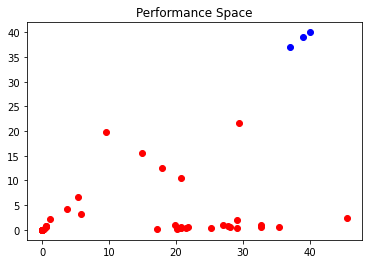

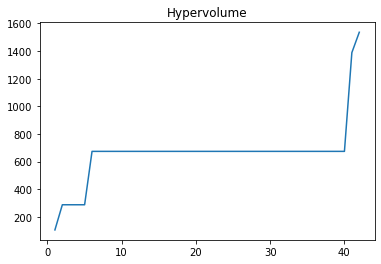

In [5]:
# plot
Y_eval = Y[Y0.shape[0]:, :]
plot_performance_space_diffcolor(Y0=-Y0, Y_eval=-Y_eval)
plot_performance_metric(Y, problem.obj_type)

In [6]:
X

array([[0.15      , 0.2       , 0.02      , 0.21      , 0.18      ,
        0.24      ],
       [0.25      , 0.31      , 0.11      , 0.02      , 0.16      ,
        0.15      ],
       [0.06      , 0.17      , 0.27      , 0.11      , 0.27      ,
        0.12      ],
       [0.        , 0.1       , 0.3       , 0.2       , 0.2       ,
        0.2       ],
       [0.35      , 0.35      , 0.        , 0.        , 0.1       ,
        0.2       ],
       [0.15      , 0.34      , 0.07      , 0.15      , 0.1       ,
        0.19      ],
       [0.13      , 0.08      , 0.16      , 0.36      , 0.02      ,
        0.25      ],
       [0.14      , 0.08      , 0.03      , 0.26      , 0.25      ,
        0.24      ],
       [0.        , 0.        , 0.5       , 0.        , 0.3       ,
        0.2       ],
       [0.        , 0.05      , 0.        , 0.25      , 0.2       ,
        0.5       ],
       [0.1       , 0.        , 0.25      , 0.25      , 0.25      ,
        0.15      ],
       [0.12      , 0

In [18]:
np.sum(x)

1.0042

In [19]:
np.round (np.sum(x), 2)

1.0